# **Pneumonia Detection**
**A machine learning project for detecting pneumonia from chest X-ray images using transfer learning and model tuning techniques.**

## **Pretrained Model Tuning**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  ConfusionMatrixDisplay,
  roc_curve,
  auc,
  precision_recall_curve,
  average_precision_score,
)
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### **Dataset Preparation**
We'll create a custom dataset class to handle our X-ray images and apply appropriate transformations for transfer learning.

In [2]:
# Import data loading function
from _data import load_pneumonia_1d


class PneumoniaDataset(Dataset):
  def __init__(self, features, labels, transform=None):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = self.features[idx]
    label = self.labels[idx]

    # Convert to tensor if not already
    if not torch.is_tensor(image):
      image = torch.tensor(image, dtype=torch.float32)

    # Reshape to (1, 224, 224) if necessary
    if image.shape != (1, 224, 224):
      image = image.reshape(1, 224, 224)

    # Apply transformations if any
    if self.transform:
      image = self.transform(image)

    return image, label

### **Data Loading & Transformation**
Define the transformations needed for pretrained models and load our dataset.

In [3]:
# Define transformations for transfer learning
train_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB (needed for pretrained models that expect 3 channels)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Data augmentation
    transforms.RandomHorizontalFlip(),  # Horizontal flips are safe for chest X-rays
    transforms.RandomRotation(5),  # Small rotation angle
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small translations
    # Normalize using ImageNet stats (required for pretrained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

test_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Normalize using ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

# Load data
train_data, test_data = load_pneumonia_1d(
  include_raw=True, include_hog=False, include_lbp=False, pca_mode="none"
)

# Split features and labels
X_train = train_data[:, :-1].reshape(-1, 1, 224, 224)
y_train = train_data[:, -1]
X_test = test_data[:, :-1].reshape(-1, 1, 224, 224)
y_test = test_data[:, -1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = PneumoniaDataset(X_train, y_train, transform=train_transforms)
test_dataset = PneumoniaDataset(X_test, y_test, transform=test_transforms)

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Training Utilities**
Define helper functions for the training process.

In [ ]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

  return train_step


def evaluate_model(model, dataloader, loss_fn, device, threshold=0.5):
  model.eval()
  all_preds = []
  all_targets = []
  all_probs = []
  cum_loss = 0
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      yhat = model(x_batch)
      val_loss = loss_fn(yhat, y_batch)
      cum_loss += val_loss.item() / len(dataloader)

      # Convert logits to probabilities
      probs = torch.sigmoid(yhat)
      all_probs.append(probs.cpu())
      # Apply the specified threshold (default is 0.5 if not provided)
      preds = (probs >= threshold).float()

      all_preds.append(preds.cpu())
      all_targets.append(y_batch.cpu())

  # Combine all batches
  all_preds = torch.cat(all_preds).numpy()
  all_targets = torch.cat(all_targets).numpy()
  all_probs = torch.cat(all_probs).numpy()

  # Compute metrics
  metrics = {
    "loss": cum_loss,
    "accuracy": accuracy_score(all_targets, all_preds),
    "precision": precision_score(all_targets, all_preds),
    "recall": recall_score(all_targets, all_preds),
    "f1": f1_score(all_targets, all_preds),
    "predictions": all_preds,
    "targets": all_targets,
    "probs": all_probs,
  }

  return metrics


def plot_metrics(train_losses, val_losses, val_metrics, title_prefix="Model"):
  plt.figure(figsize=(13, 13))

  # Plot losses
  plt.subplot(2, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"{title_prefix} - Loss over Epochs")
  plt.legend()
  plt.grid(True)

  # Plot accuracy
  plt.subplot(2, 2, 2)
  plt.plot([metrics["accuracy"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f"{title_prefix} - Validation Accuracy")
  plt.grid(True)

  # Plot F1 score
  plt.subplot(2, 2, 3)
  plt.plot([metrics["f1"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.title(f"{title_prefix} - Validation F1 Score")
  plt.grid(True)

  # Plot precision and recall
  plt.subplot(2, 2, 4)
  plt.plot([metrics["precision"] for metrics in val_metrics], label="Precision")
  plt.plot([metrics["recall"] for metrics in val_metrics], label="Recall")
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title(f"{title_prefix} - Validation Precision and Recall")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


def plot_learning_curve(
  train_metrics_history, val_metrics_history, ax, title="Learning Curve"
):
  epochs = np.arange(1, len(val_metrics_history) + 1)
  train_f1_scores = [metrics["f1"] for metrics in train_metrics_history]
  val_f1_scores = [metrics["f1"] for metrics in val_metrics_history]

  # Calculate moving standard deviation with window size of 3
  # This simulates variance you might see across different runs
  def moving_std(data, window=3):
    if len(data) < window:
      return np.zeros_like(data)
    result = np.zeros_like(data)
    for i in range(len(data)):
      start = max(0, i - window // 2)
      end = min(len(data), i + window // 2 + 1)
      result[i] = np.std(data[start:end])
    return result

  train_std = moving_std(train_f1_scores)
  val_std = moving_std(val_f1_scores)

  ax.grid(True)
  ax.set_xlim(0.5, len(epochs) + 0.5)
  ax.set_xlabel("Epochs")
  ax.set_ylim(0.0, 1.05)
  ax.set_ylabel("F1 Score")

  ax.fill_between(
    epochs,
    np.array(train_f1_scores) - train_std,
    np.array(train_f1_scores) + train_std,
    alpha=0.1,
    color="r",
  )

  ax.fill_between(
    epochs,
    np.array(val_f1_scores) - val_std,
    np.array(val_f1_scores) + val_std,
    alpha=0.1,
    color="g",
  )

  ax.plot(epochs, train_f1_scores, "o-", color="r", label="Training F1 Score")
  ax.plot(epochs, val_f1_scores, "o-", color="g", label="Validation F1 Score")

  ax.legend(loc="best")
  ax.set_title(title)


def plot_confusion_matrix(y_true, y_pred, ax, title="Confusion Matrix"):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  disp.ax_.set_title(title)
  disp.ax_.set_xlabel("Predicted Label")
  disp.ax_.set_ylabel("True Label")


def plot_aucroc_curve(y_true, y_scores, ax, title="ROC Curve"):
  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  pd.DataFrame({"fpr": fpr, "tpr": tpr}).plot(
    "fpr",
    "tpr",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    label=f"AUC = {roc_auc:.3f}",
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    grid=True,
    title=title,
    ax=ax,
  )
  ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
  ax.legend(loc="lower right")


def plot_prcrcl_curve(y_true, y_scores, ax, title="Precision-Recall Curve"):
  # Calculate precision, recall, and AP
  precision, recall, _ = precision_recall_curve(y_true, y_scores)
  avg_precision = average_precision_score(y_true, y_scores)

  pd.DataFrame({"recall": recall, "precision": precision}).plot(
    "recall",
    "precision",
    xlabel="Recall",
    ylabel="Precision",
    label=f"AP = {avg_precision:.3f}",
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    grid=True,
    title=title,
    ax=ax,
  )
  no_skill = np.sum(y_true) / len(y_true)
  ax.plot([0, 1], [no_skill, no_skill], color="gray", linestyle="--")
  ax.legend(loc="lower left")

### **Model Architecture**
Load pretrained models and modify them for our pneumonia classification task.

In [ ]:
def create_resnet_model():
  model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
  for param in model.parameters():
    param.requires_grad = False

  for param in model.layer4.parameters():
    param.requires_grad = True

  # Replace the final layer for binary classification
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_densenet_model():
  model = torchvision.models.densenet121(weights="IMAGENET1K_V1")

  for param in model.parameters():
    param.requires_grad = False

  for param in model.features.denseblock4.parameters():
    param.requires_grad = True
  for param in model.features.norm5.parameters():
    param.requires_grad = True

  # Replace the final layer for binary classification
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_efficientnet_model():
  model = torchvision.models.efficientnet_b0(weights="IMAGENET1K_V1")

  for param in model.parameters():
    param.requires_grad = False

  for i in range(6, 8):
    for param in model.features[i].parameters():
      param.requires_grad = True

  # Replace the classifier for binary classification
  num_ftrs = model.classifier[1].in_features
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), nn.Linear(num_ftrs, 1)
  )

  return model.to(device)


def create_vit_model():
  model = torchvision.models.vit_b_16(weights="IMAGENET1K_V1")

  num_blocks = len(model.encoder.layers)
  for i in range(num_blocks - 2, num_blocks):
    for param in model.encoder.layers[i].parameters():
      param.requires_grad = True

  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.heads.head.in_features
  model.heads.head = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_swin_model():
  model = torchvision.models.swin_t(weights="IMAGENET1K_V1")

  for param in model.parameters():
    param.requires_grad = False

  for param in model.features[-1].parameters():
    param.requires_grad = True

  # Replace the final layer for binary classification
  num_ftrs = model.head.in_features
  model.head = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_convnext_model():
  model = torchvision.models.convnext_tiny(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  for param in model.features[-2].parameters():  # Last stage before norm layer
    param.requires_grad = True

  # Replace the final layer for binary classification
  num_ftrs = model.classifier[2].in_features
  model.classifier = nn.Sequential(
    nn.Flatten(1), nn.LayerNorm([num_ftrs]), nn.Linear(num_ftrs, 1)
  )

  return model.to(device)

### **Threshold Tuning**

In [ ]:
def tune_threshold(model, dataloader, device, thresholds=None):
  if thresholds is None:
    thresholds = np.arange(0.1, 0.9, 0.05)

  model.eval()
  all_probs = []
  all_targets = []

  # Collect all predictions and targets
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      yhat = model(x_batch)
      probs = torch.sigmoid(yhat)

      all_probs.append(probs.cpu())
      all_targets.append(y_batch.cpu())

  # Combine all batches
  all_probs = torch.cat(all_probs).numpy()
  all_targets = torch.cat(all_targets).numpy()

  # Test different thresholds
  results = {}
  best_f1 = 0
  best_threshold = 0.5

  for threshold in thresholds:
    preds = (all_probs >= threshold).astype(float)

    # Compute metrics
    acc = accuracy_score(all_targets, preds)
    prec = precision_score(all_targets, preds)
    rec = recall_score(all_targets, preds)
    f1 = f1_score(all_targets, preds)

    results[threshold] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    if f1 > best_f1:
      best_f1 = f1
      best_threshold = threshold

  return best_threshold, results

### **Training Loop**
Define the training process with early stopping and learning rate scheduling.

In [7]:
def train_model(
  model, trainloader, testloader, model_name="Model", n_epochs=20, patience=3
):
  # Calculate class weights for balanced loss
  y_train_np = y_train.cpu().numpy()
  class_weights = compute_class_weight(
    "balanced", classes=np.array([0, 1]), y=y_train_np.flatten()
  )
  pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)
  print(f"Class weights: {class_weights}")
  print(f"Positive class weight: {pos_weight.item()}")

  # Loss function and optimizer
  loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
  optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
  )
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.5
  )

  # Training step function
  train_step = make_train_step(model, optimizer, loss_fn)

  # Initialize tracking variables
  best_loss = float("inf")
  early_stopping_counter = 0
  best_model_weights = None

  train_losses = []
  val_losses = []
  train_metrics_history = []
  val_metrics_history = []

  # Training loop
  for epoch in range(n_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    all_train_outputs = []
    all_train_targets = []
    for i, data in tqdm(
      enumerate(trainloader),
      total=len(trainloader),
      desc=f"Epoch {epoch + 1}/{n_epochs}",
    ):
      x_batch, y_batch = data
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      loss = train_step(x_batch, y_batch)
      epoch_loss += loss / len(trainloader)

      with torch.no_grad():
        outputs = model(x_batch)
        all_train_outputs.append(outputs.cpu())
        all_train_targets.append(y_batch.cpu())

    train_losses.append(epoch_loss)
    with torch.no_grad():
      model.eval()  # Set model to evaluation mode
      all_train_outputs = torch.cat(all_train_outputs, dim=0)
      all_train_targets = torch.cat(all_train_targets, dim=0)

      # Convert outputs to probabilities
      train_probs = torch.sigmoid(all_train_outputs).numpy()
      train_targets = all_train_targets.numpy()

      # Use default threshold of 0.5 for now
      train_preds = (train_probs >= 0.5).astype(int)

      # Calculate metrics
      train_metrics = {
        "loss": epoch_loss,
        "accuracy": accuracy_score(train_targets, train_preds),
        "precision": precision_score(train_targets, train_preds, zero_division=0),
        "recall": recall_score(train_targets, train_preds, zero_division=0),
        "f1": f1_score(train_targets, train_preds, zero_division=0),
        "probs": train_probs,
        "predictions": train_preds,
        "targets": train_targets,
      }

      train_metrics_history.append(train_metrics)

    print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {epoch_loss:.4f}")
    print(
      f"Training Accuracy: {train_metrics['accuracy']:.4f}, "
      f"Precision: {train_metrics['precision']:.4f}, Recall: {train_metrics['recall']:.4f}, "
      f"F1 Score: {train_metrics['f1']:.4f}"
    )

    # Validation phase
    val_metrics = evaluate_model(model, testloader, loss_fn, device)
    val_loss = val_metrics["loss"]
    val_losses.append(val_loss)
    val_metrics_history.append(val_metrics)

    print(
      f"Validation Loss: {val_loss:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, "
      f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, "
      f"F1 Score: {val_metrics['f1']:.4f}"
    )

    # Update learning rate
    scheduler.step(val_loss)

    # Check for improvement and early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_weights = model.state_dict().copy()
      early_stopping_counter = 0
      print(f"New best validation loss: {best_loss:.4f}")
    else:
      early_stopping_counter += 1
      print(f"No improvement for {early_stopping_counter} epochs")

    if early_stopping_counter >= patience:
      print("Early stopping triggered")
      break

  # Load best model weights
  if best_model_weights:
    model.load_state_dict(best_model_weights)
    print(f"Loaded best model with validation loss: {best_loss:.4f}")

  best_threshold, threshold_results = tune_threshold(model, testloader, device)
  print(
    f"Best threshold: {best_threshold:.2f} with F1 score: {threshold_results[best_threshold]['f1']:.4f}"
  )
  # Final evaluation
  final_metrics = evaluate_model(
    model, testloader, loss_fn, device, threshold=best_threshold
  )
  print("\n=== Final Model Evaluation ===")
  print(f"Loss: {final_metrics['loss']:.4f}")
  print(f"Accuracy: {final_metrics['accuracy']:.4f}")
  print(f"Precision: {final_metrics['precision']:.4f}")
  print(f"Recall: {final_metrics['recall']:.4f}")
  print(f"F1 Score: {final_metrics['f1']:.4f}")

  # Plot metrics
  plot_metrics(train_losses, val_losses, val_metrics_history, title_prefix=model_name)

  # Plot confusion matrix
  _, axs = plt.subplots(1, 4, figsize=(26, 6.5))
  plot_learning_curve(
    train_metrics_history,
    val_metrics_history,
    ax=axs[0],
    title=f"{model_name} Learning Curve",
  )
  plot_confusion_matrix(
    final_metrics["targets"],
    final_metrics["predictions"],
    ax=axs[1],
    title=f"{model_name} Confusion Matrix",
  )

  plot_aucroc_curve(
    final_metrics["targets"],
    final_metrics["probs"],
    ax=axs[2],
    title=f"{model_name} AUR-ROC Curve",
  )

  plot_prcrcl_curve(
    final_metrics["targets"],
    final_metrics["probs"],
    ax=axs[3],
    title=f"{model_name} Precision-Recall Curve",
  )

  plt.tight_layout()
  plt.show()

  return model, final_metrics

### **Model Tuning: ResNet18**
Train and evaluate a fine-tuned ResNet18 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [04:49<00:00,  1.76s/it]


Epoch 1/20, Training Loss: 0.0697
Training Accuracy: 0.9694, Precision: 0.9942, Recall: 0.9645, F1 Score: 0.9791
Validation Loss: 0.3644, Accuracy: 0.8910, Precision: 0.8562, Recall: 0.9923, F1 Score: 0.9192
New best validation loss: 0.3644


Epoch 2/20: 100%|██████████| 164/164 [04:43<00:00,  1.73s/it]


Epoch 2/20, Training Loss: 0.0379
Training Accuracy: 0.9822, Precision: 0.9974, Recall: 0.9786, F1 Score: 0.9879
Validation Loss: 0.2493, Accuracy: 0.9071, Precision: 0.9089, Recall: 0.9462, F1 Score: 0.9271
New best validation loss: 0.2493


Epoch 3/20: 100%|██████████| 164/164 [04:36<00:00,  1.68s/it]


Epoch 3/20, Training Loss: 0.0341
Training Accuracy: 0.9830, Precision: 0.9979, Recall: 0.9791, F1 Score: 0.9884
Validation Loss: 0.4138, Accuracy: 0.8894, Precision: 0.8575, Recall: 0.9872, F1 Score: 0.9178
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [04:36<00:00,  1.69s/it]


Epoch 4/20, Training Loss: 0.0284
Training Accuracy: 0.9832, Precision: 0.9987, Recall: 0.9786, F1 Score: 0.9886
Validation Loss: 0.6762, Accuracy: 0.8622, Precision: 0.8220, Recall: 0.9949, F1 Score: 0.9002
No improvement for 2 epochs


Epoch 5/20: 100%|██████████| 164/164 [04:39<00:00,  1.70s/it]


Epoch 5/20, Training Loss: 0.0261
Training Accuracy: 0.9880, Precision: 0.9982, Recall: 0.9856, F1 Score: 0.9918
Validation Loss: 0.8637, Accuracy: 0.8413, Precision: 0.8012, Recall: 0.9923, F1 Score: 0.8866
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2493
Best threshold: 0.85 with F1 score: 0.9167

=== Final Model Evaluation ===
Loss: 0.8637
Accuracy: 0.8878
Precision: 0.8556
Recall: 0.9872
F1 Score: 0.9167


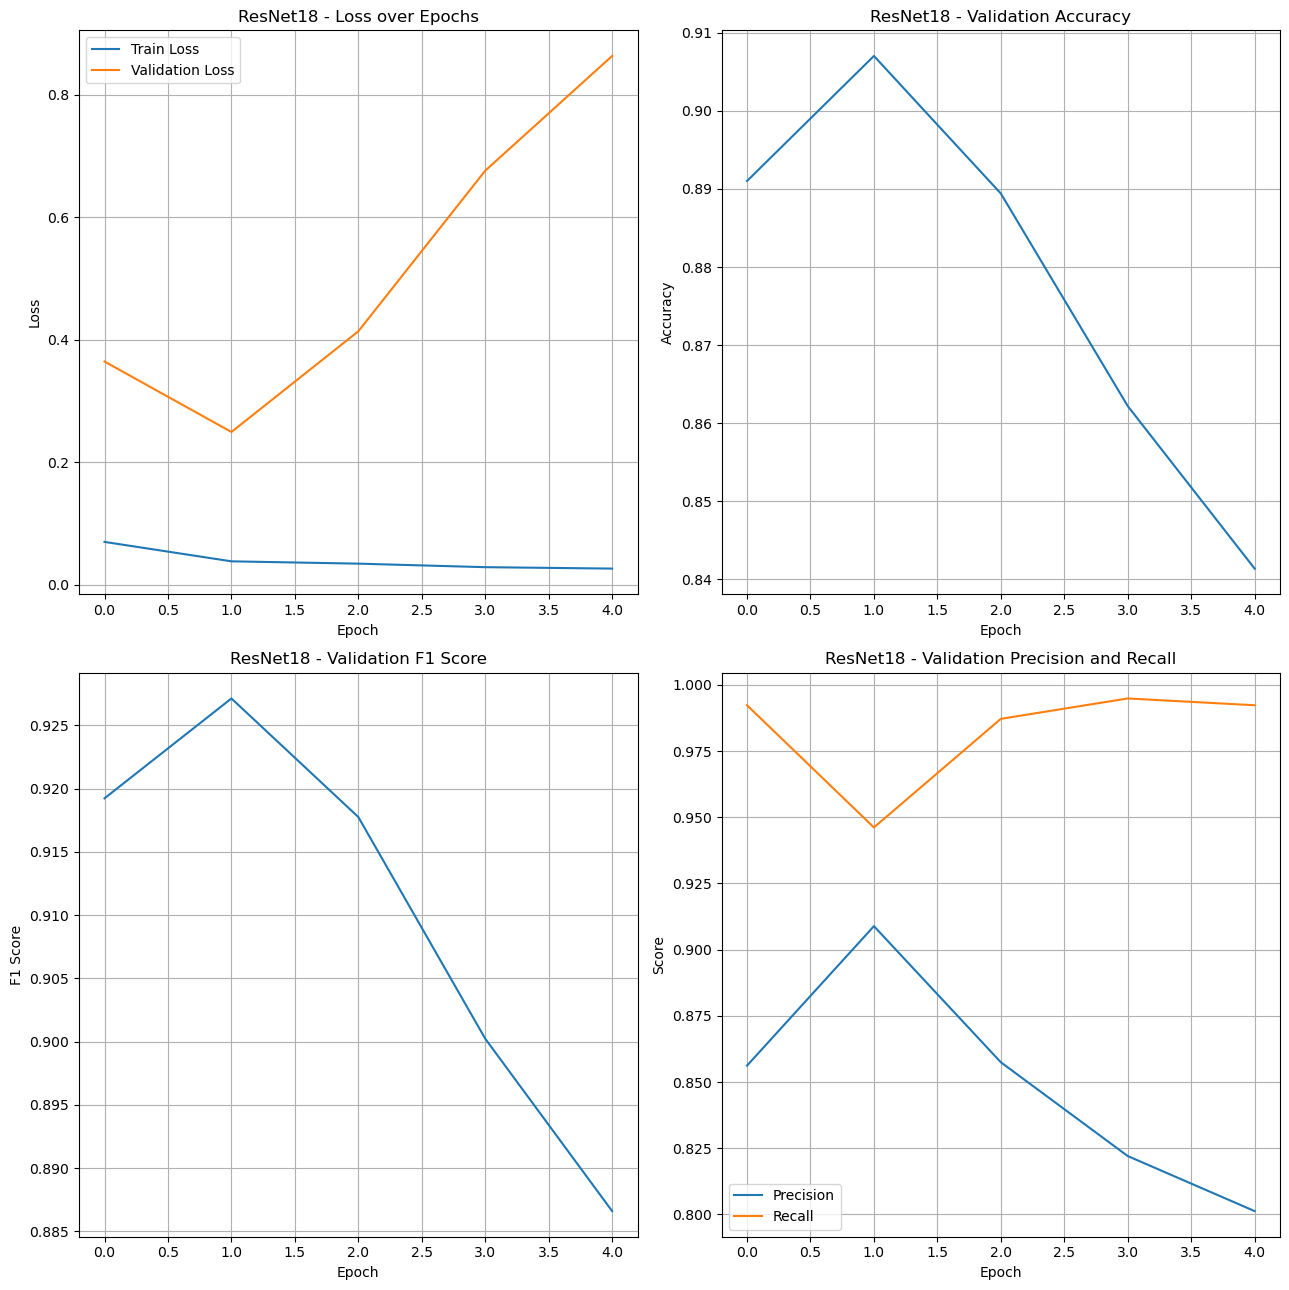

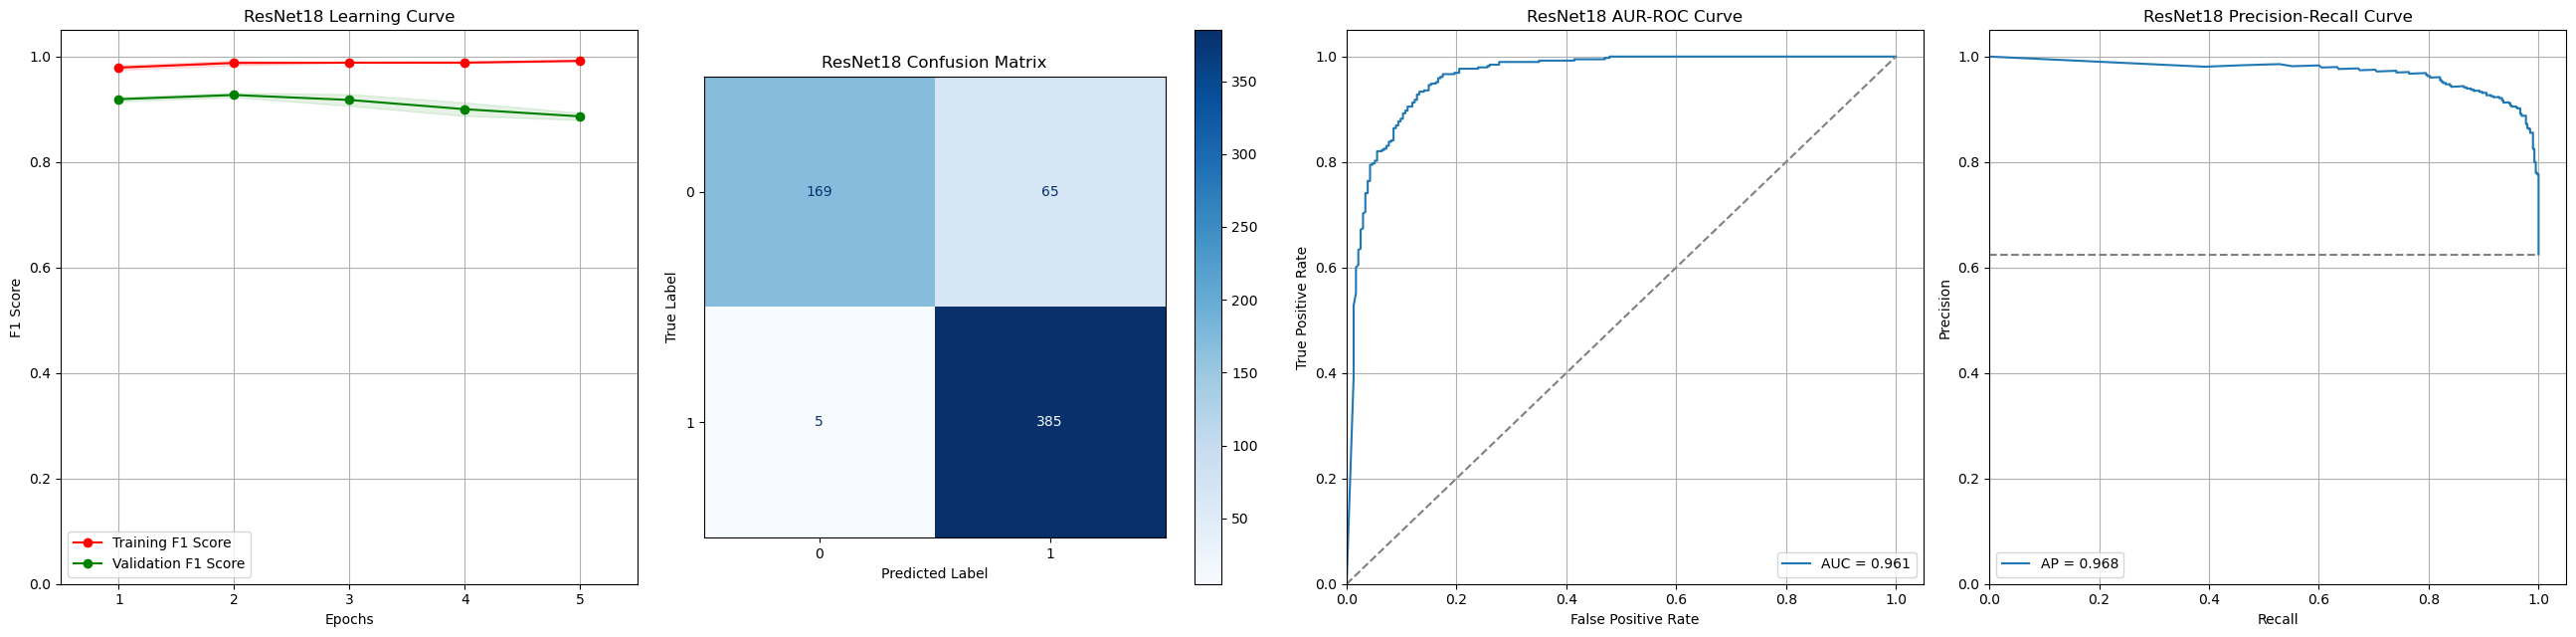

In [8]:
# Create and train ResNet18 model
resnet_model = create_resnet_model()
resnet_model, resnet_metrics = train_model(
  resnet_model, trainloader, testloader, model_name="ResNet18"
)

### **Model Tuning: DenseNet121**
Train and evaluate a fine-tuned DenseNet121 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [15:55<00:00,  5.83s/it]


Epoch 1/20, Training Loss: 0.0733
Training Accuracy: 0.9679, Precision: 0.9955, Recall: 0.9611, F1 Score: 0.9780
Validation Loss: 0.3887, Accuracy: 0.8910, Precision: 0.8659, Recall: 0.9769, F1 Score: 0.9181
New best validation loss: 0.3887


Epoch 2/20: 100%|██████████| 164/164 [15:46<00:00,  5.77s/it]


Epoch 2/20, Training Loss: 0.0414
Training Accuracy: 0.9752, Precision: 0.9966, Recall: 0.9699, F1 Score: 0.9830
Validation Loss: 0.3367, Accuracy: 0.9022, Precision: 0.8799, Recall: 0.9769, F1 Score: 0.9259
New best validation loss: 0.3367


Epoch 3/20: 100%|██████████| 164/164 [16:04<00:00,  5.88s/it]


Epoch 3/20, Training Loss: 0.0330
Training Accuracy: 0.9830, Precision: 0.9976, Recall: 0.9794, F1 Score: 0.9884
Validation Loss: 0.4031, Accuracy: 0.8942, Precision: 0.8632, Recall: 0.9872, F1 Score: 0.9211
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [15:45<00:00,  5.76s/it]


Epoch 4/20, Training Loss: 0.0281
Training Accuracy: 0.9874, Precision: 0.9992, Recall: 0.9838, F1 Score: 0.9914
Validation Loss: 0.3914, Accuracy: 0.9071, Precision: 0.8756, Recall: 0.9923, F1 Score: 0.9303
No improvement for 2 epochs


Epoch 5/20: 100%|██████████| 164/164 [15:48<00:00,  5.78s/it]


Epoch 5/20, Training Loss: 0.0250
Training Accuracy: 0.9891, Precision: 0.9992, Recall: 0.9861, F1 Score: 0.9926
Validation Loss: 0.6243, Accuracy: 0.8670, Precision: 0.8330, Recall: 0.9846, F1 Score: 0.9025
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.3367
Best threshold: 0.85 with F1 score: 0.9186

=== Final Model Evaluation ===
Loss: 0.6243
Accuracy: 0.8926
Precision: 0.8730
Recall: 0.9692
F1 Score: 0.9186


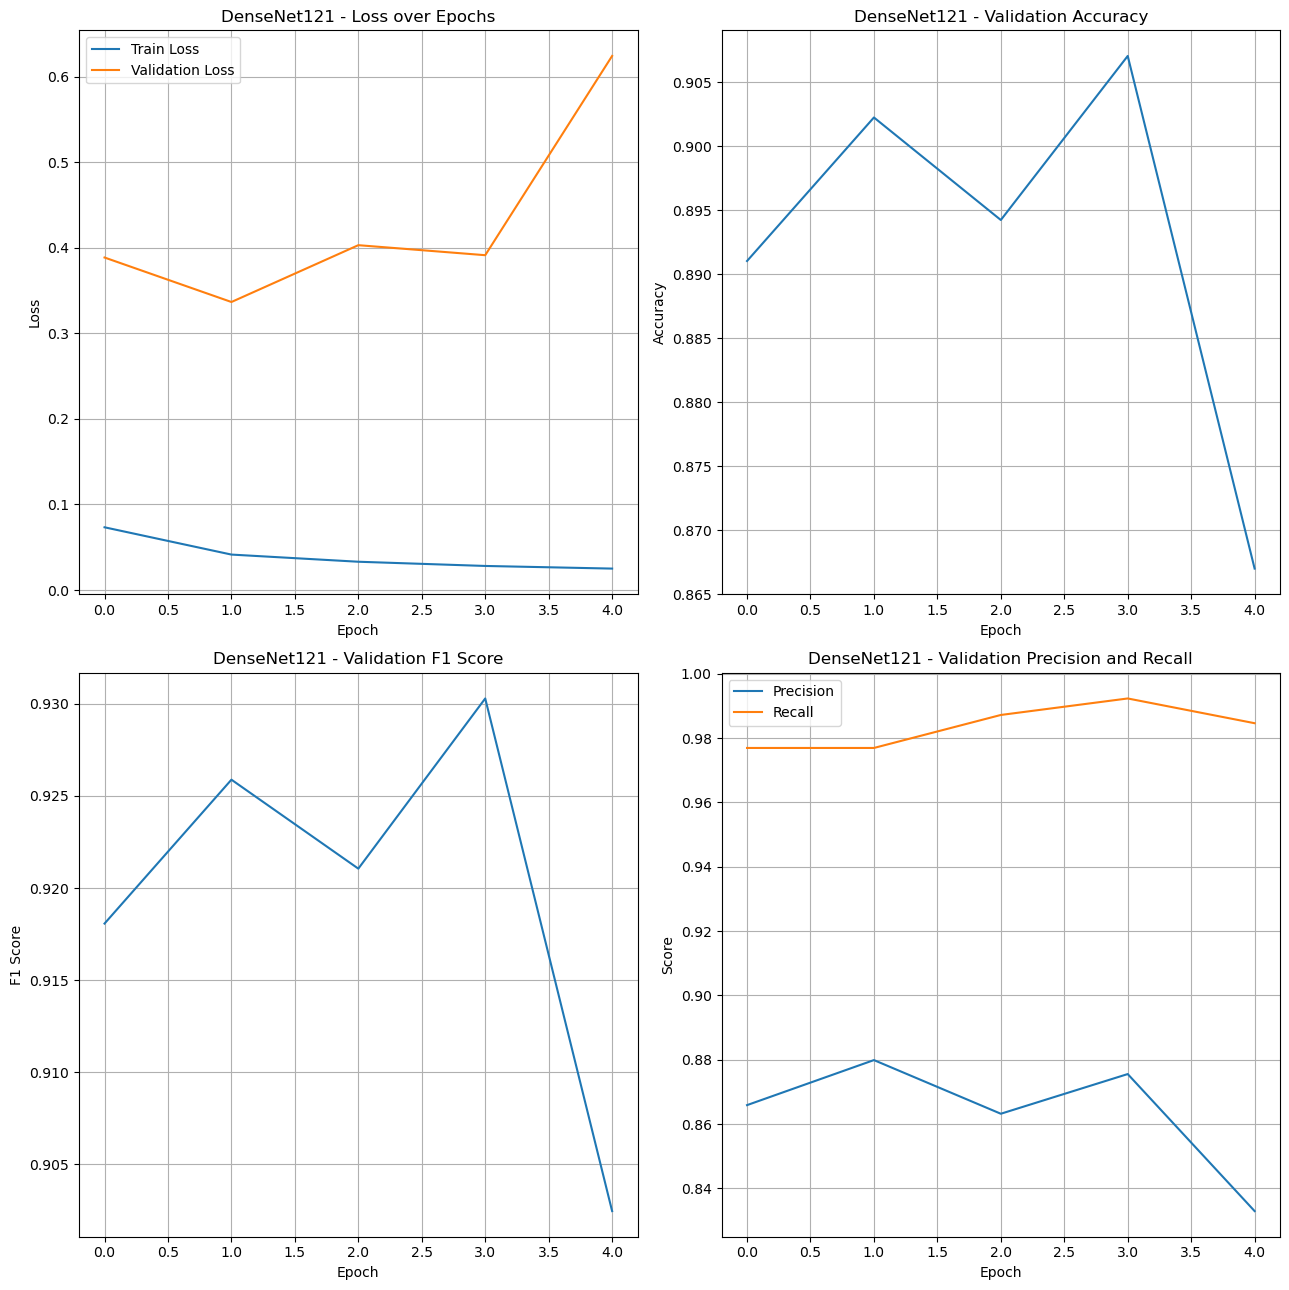

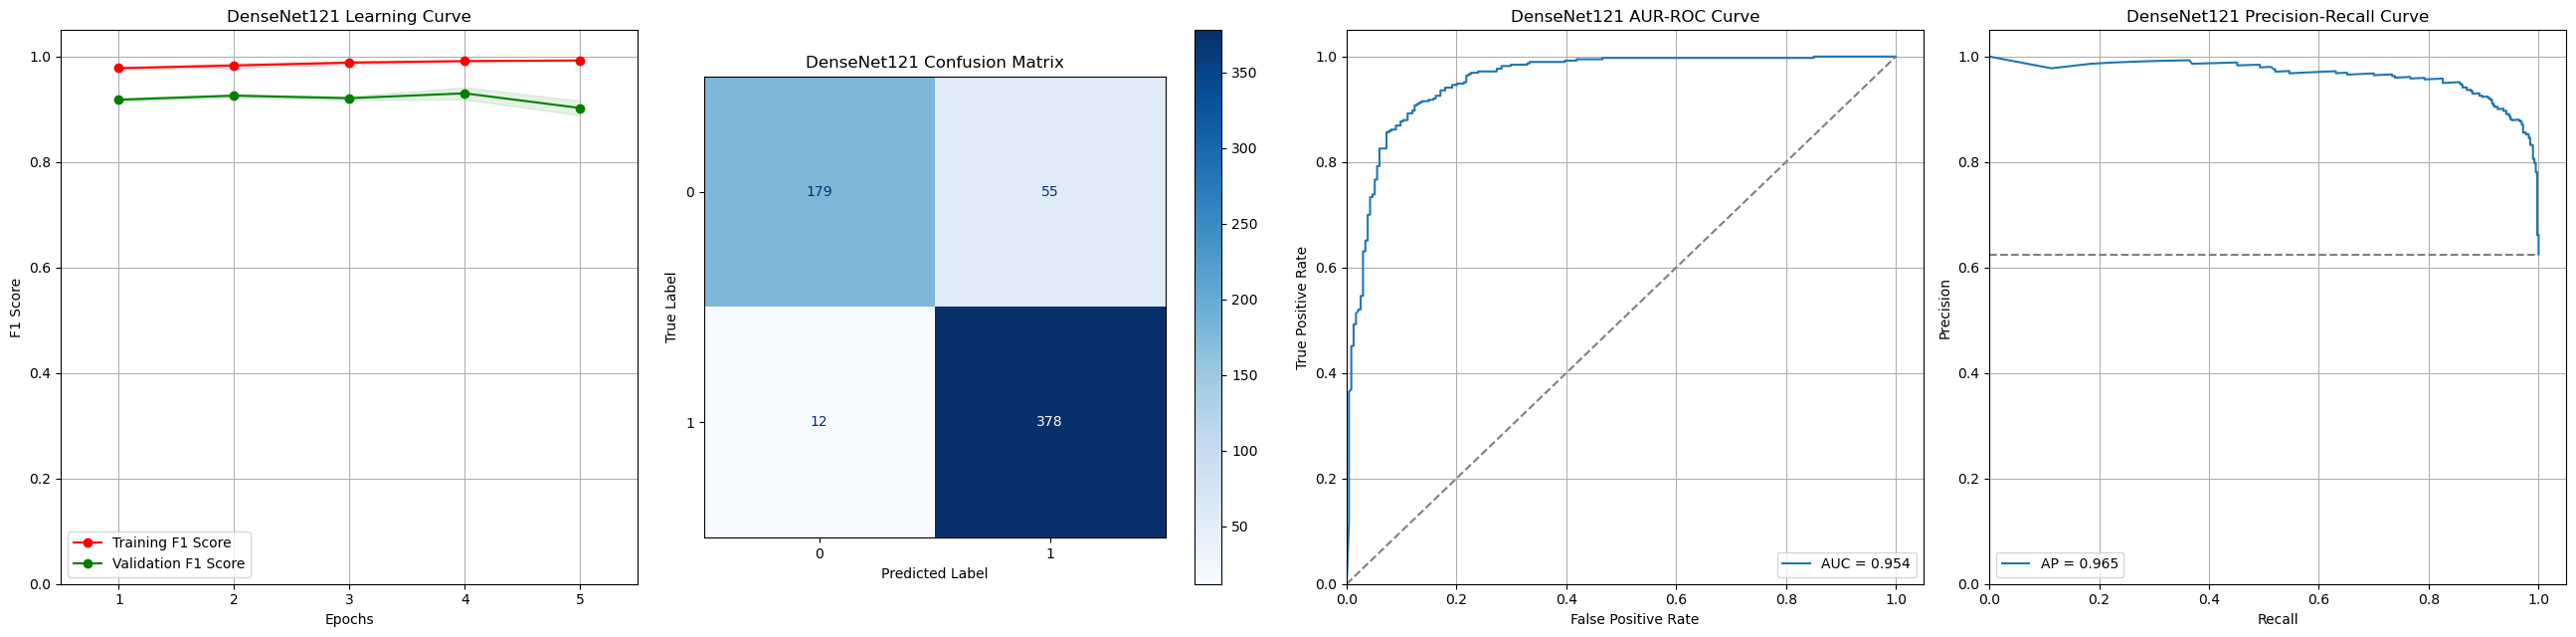

In [9]:
# Create and train DenseNet121 model
densenet_model = create_densenet_model()
densenet_model, densenet_metrics = train_model(
  densenet_model, trainloader, testloader, model_name="DenseNet121"
)

### **Model Tuning: EfficientNet-B0**
Train and evaluate a fine-tuned EfficientNet-B0 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [12:56<00:00,  4.74s/it]


Epoch 1/20, Training Loss: 0.0800
Training Accuracy: 0.9560, Precision: 0.9930, Recall: 0.9475, F1 Score: 0.9697
Validation Loss: 0.5621, Accuracy: 0.8510, Precision: 0.8207, Recall: 0.9744, F1 Score: 0.8910
New best validation loss: 0.5621


Epoch 2/20: 100%|██████████| 164/164 [11:46<00:00,  4.31s/it]


Epoch 2/20, Training Loss: 0.0384
Training Accuracy: 0.9750, Precision: 0.9963, Recall: 0.9699, F1 Score: 0.9829
Validation Loss: 0.5690, Accuracy: 0.8654, Precision: 0.8312, Recall: 0.9846, F1 Score: 0.9014
No improvement for 1 epochs


Epoch 3/20: 100%|██████████| 164/164 [11:47<00:00,  4.32s/it]


Epoch 3/20, Training Loss: 0.0368
Training Accuracy: 0.9784, Precision: 0.9982, Recall: 0.9727, F1 Score: 0.9853
Validation Loss: 0.7995, Accuracy: 0.8301, Precision: 0.7898, Recall: 0.9923, F1 Score: 0.8795
No improvement for 2 epochs


Epoch 4/20: 100%|██████████| 164/164 [12:13<00:00,  4.47s/it]


Epoch 4/20, Training Loss: 0.0243
Training Accuracy: 0.9866, Precision: 0.9982, Recall: 0.9838, F1 Score: 0.9909
Validation Loss: 0.3416, Accuracy: 0.9199, Precision: 0.9087, Recall: 0.9692, F1 Score: 0.9380
New best validation loss: 0.3416


Epoch 5/20: 100%|██████████| 164/164 [12:00<00:00,  4.39s/it]


Epoch 5/20, Training Loss: 0.0242
Training Accuracy: 0.9836, Precision: 0.9971, Recall: 0.9807, F1 Score: 0.9888
Validation Loss: 0.9472, Accuracy: 0.8301, Precision: 0.7886, Recall: 0.9949, F1 Score: 0.8798
No improvement for 1 epochs


Epoch 6/20: 100%|██████████| 164/164 [12:22<00:00,  4.53s/it]


Epoch 6/20, Training Loss: 0.0184
Training Accuracy: 0.9904, Precision: 0.9992, Recall: 0.9879, F1 Score: 0.9935
Validation Loss: 0.8173, Accuracy: 0.8766, Precision: 0.8395, Recall: 0.9923, F1 Score: 0.9095
No improvement for 2 epochs


Epoch 7/20: 100%|██████████| 164/164 [12:00<00:00,  4.39s/it]


Epoch 7/20, Training Loss: 0.0222
Training Accuracy: 0.9897, Precision: 0.9979, Recall: 0.9882, F1 Score: 0.9930
Validation Loss: 0.5516, Accuracy: 0.8910, Precision: 0.8610, Recall: 0.9846, F1 Score: 0.9187
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.3416
Best threshold: 0.80 with F1 score: 0.9296

=== Final Model Evaluation ===
Loss: 0.5516
Accuracy: 0.9071
Precision: 0.8825
Recall: 0.9821
F1 Score: 0.9296


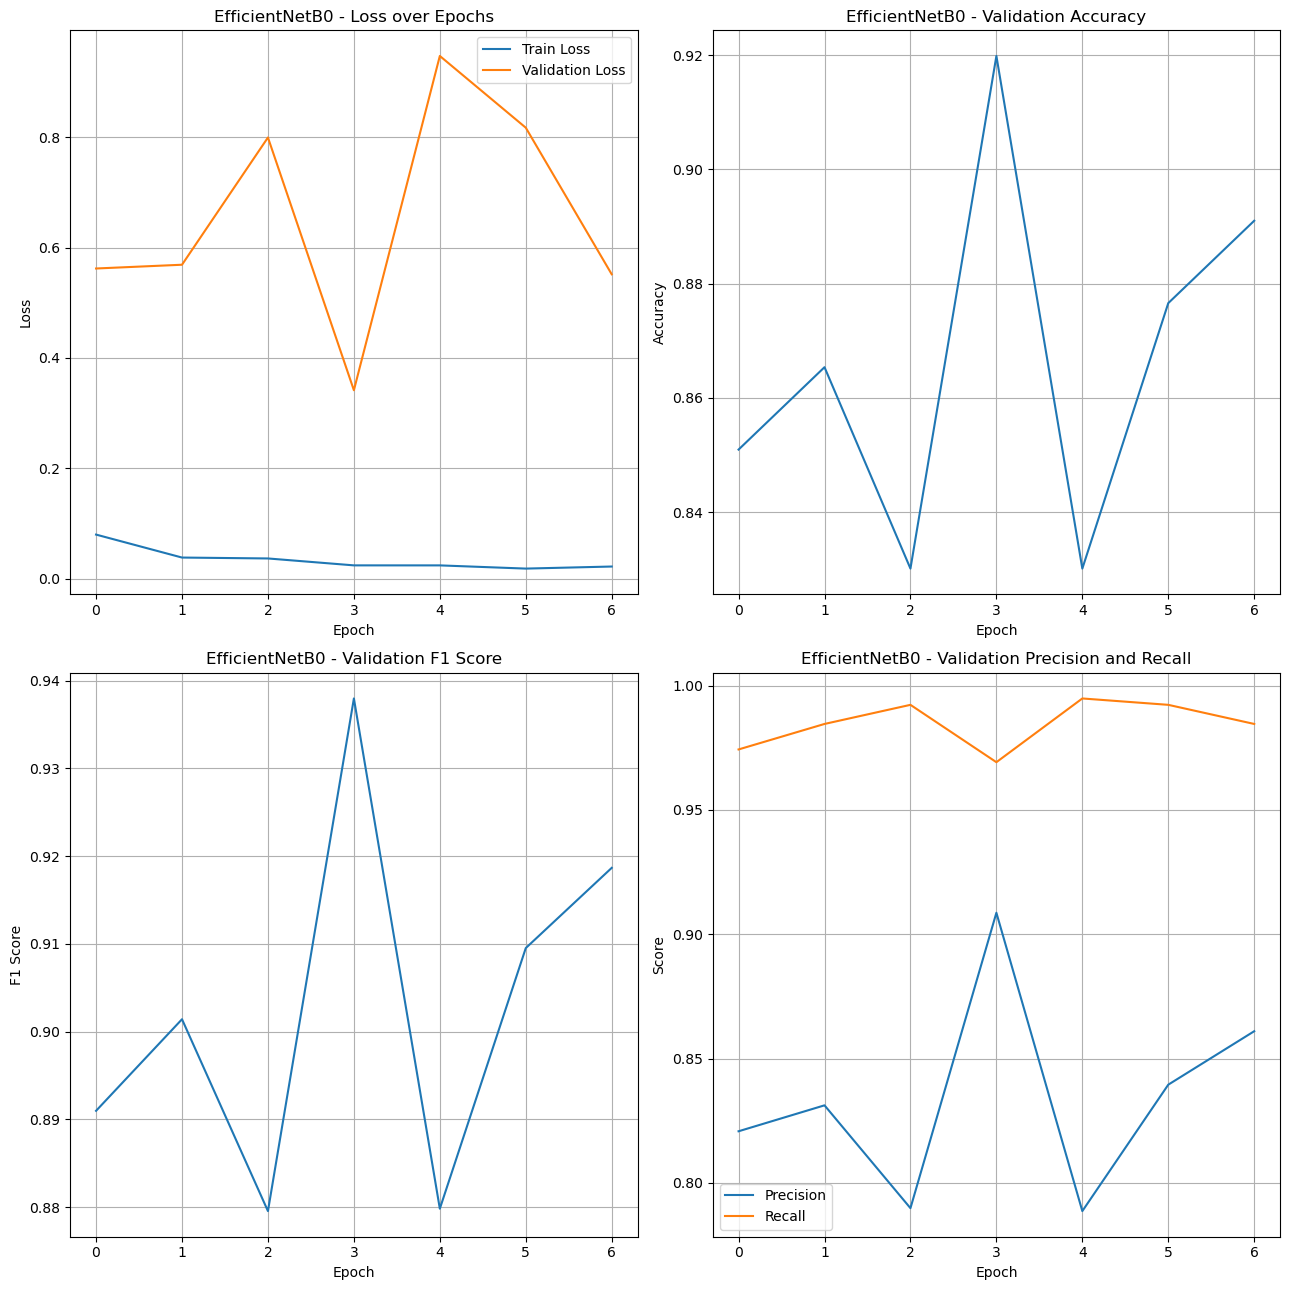

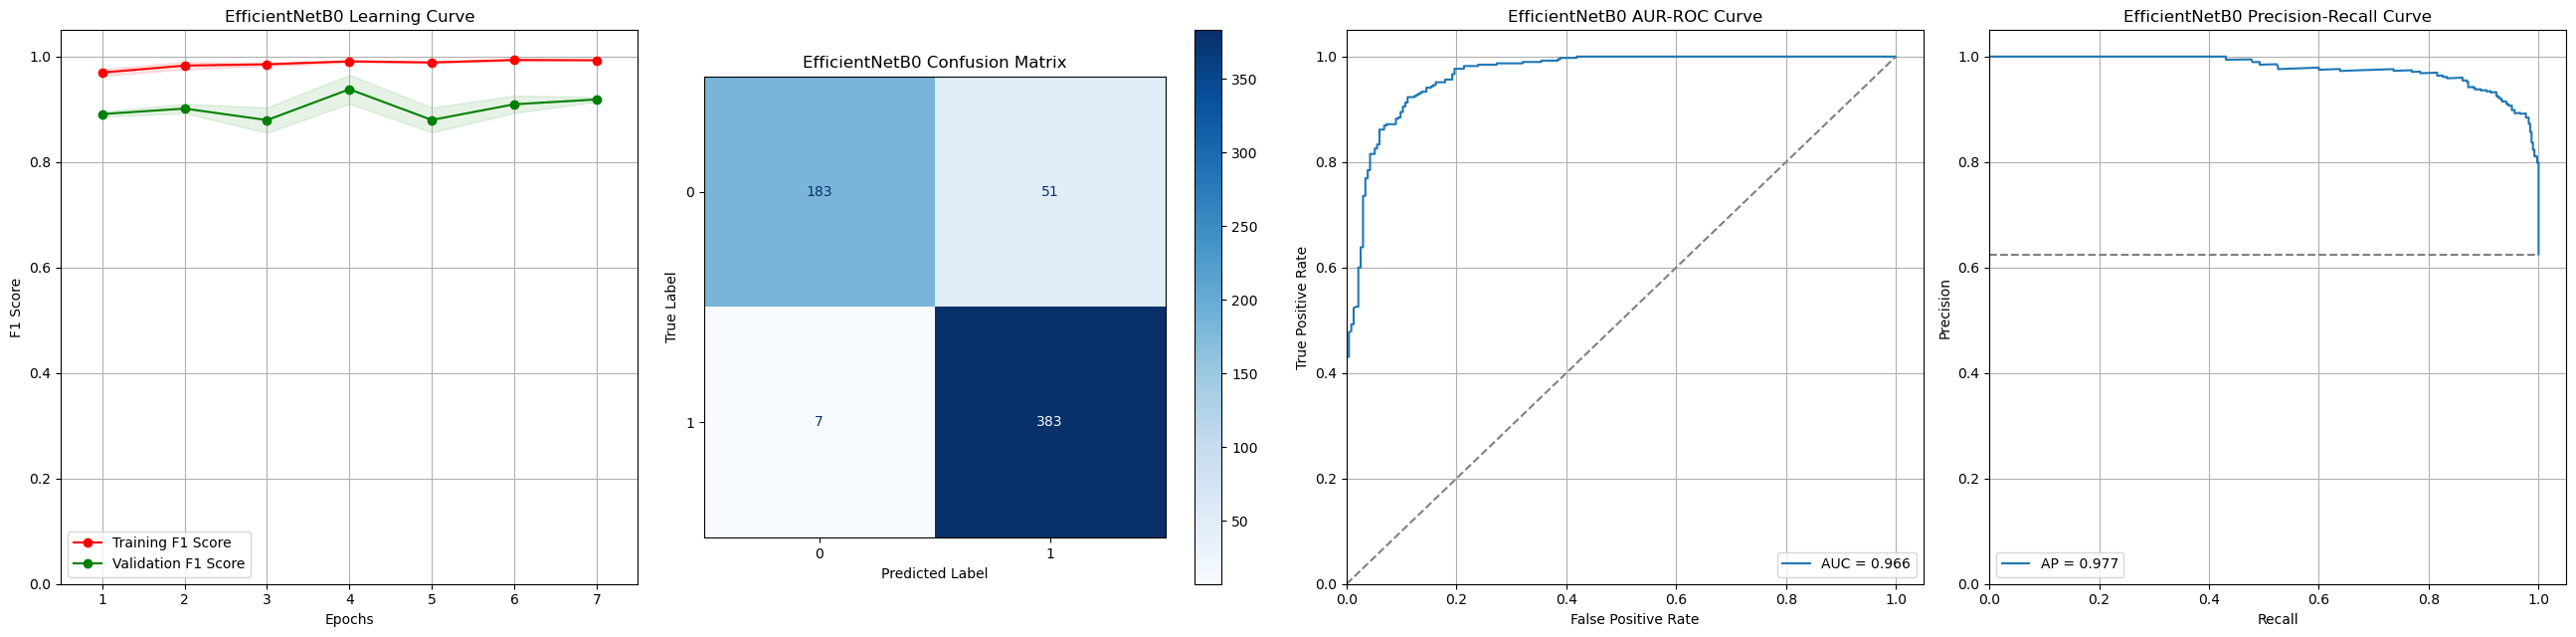

In [10]:
# Create and train EfficientNet model
efficientnet_model = create_efficientnet_model()
efficientnet_model, efficientnet_metrics = train_model(
  efficientnet_model, trainloader, testloader, model_name="EfficientNetB0"
)

### **Model Tuning: ViT-B/16**
Train and evaluate a fine-tuned ViT-B/16 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [09:47<00:00,  3.58s/it]


Epoch 1/20, Training Loss: 0.1596
Training Accuracy: 0.8631, Precision: 0.9651, Recall: 0.8463, F1 Score: 0.9018
Validation Loss: 0.3188, Accuracy: 0.8061, Precision: 0.8050, Recall: 0.9103, F1 Score: 0.8544
New best validation loss: 0.3188


Epoch 2/20: 100%|██████████| 164/164 [10:14<00:00,  3.74s/it]


Epoch 2/20, Training Loss: 0.1019
Training Accuracy: 0.9205, Precision: 0.9801, Recall: 0.9114, F1 Score: 0.9445
Validation Loss: 0.3138, Accuracy: 0.8413, Precision: 0.8226, Recall: 0.9513, F1 Score: 0.8823
New best validation loss: 0.3138


Epoch 3/20: 100%|██████████| 164/164 [09:48<00:00,  3.59s/it]


Epoch 3/20, Training Loss: 0.0863
Training Accuracy: 0.9297, Precision: 0.9851, Recall: 0.9191, F1 Score: 0.9510
Validation Loss: 0.3007, Accuracy: 0.8542, Precision: 0.8390, Recall: 0.9487, F1 Score: 0.8905
New best validation loss: 0.3007


Epoch 4/20: 100%|██████████| 164/164 [09:29<00:00,  3.47s/it]


Epoch 4/20, Training Loss: 0.0803
Training Accuracy: 0.9364, Precision: 0.9847, Recall: 0.9287, F1 Score: 0.9559
Validation Loss: 0.3066, Accuracy: 0.8558, Precision: 0.8333, Recall: 0.9615, F1 Score: 0.8929
No improvement for 1 epochs


Epoch 5/20: 100%|██████████| 164/164 [09:57<00:00,  3.64s/it]


Epoch 5/20, Training Loss: 0.0746
Training Accuracy: 0.9427, Precision: 0.9846, Recall: 0.9374, F1 Score: 0.9604
Validation Loss: 0.2709, Accuracy: 0.8654, Precision: 0.8558, Recall: 0.9436, F1 Score: 0.8976
New best validation loss: 0.2709


Epoch 6/20: 100%|██████████| 164/164 [10:05<00:00,  3.69s/it]


Epoch 6/20, Training Loss: 0.0710
Training Accuracy: 0.9451, Precision: 0.9852, Recall: 0.9403, F1 Score: 0.9622
Validation Loss: 0.2744, Accuracy: 0.8670, Precision: 0.8497, Recall: 0.9564, F1 Score: 0.8999
No improvement for 1 epochs


Epoch 7/20: 100%|██████████| 164/164 [10:09<00:00,  3.71s/it]


Epoch 7/20, Training Loss: 0.0677
Training Accuracy: 0.9507, Precision: 0.9868, Recall: 0.9462, F1 Score: 0.9661
Validation Loss: 0.3572, Accuracy: 0.8381, Precision: 0.8081, Recall: 0.9718, F1 Score: 0.8824
No improvement for 2 epochs


Epoch 8/20: 100%|██████████| 164/164 [10:02<00:00,  3.67s/it]


Epoch 8/20, Training Loss: 0.0645
Training Accuracy: 0.9528, Precision: 0.9882, Recall: 0.9477, F1 Score: 0.9675
Validation Loss: 0.2925, Accuracy: 0.8702, Precision: 0.8503, Recall: 0.9615, F1 Score: 0.9025
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2709
Best threshold: 0.55 with F1 score: 0.9064

=== Final Model Evaluation ===
Loss: 0.2925
Accuracy: 0.8766
Precision: 0.8614
Recall: 0.9564
F1 Score: 0.9064


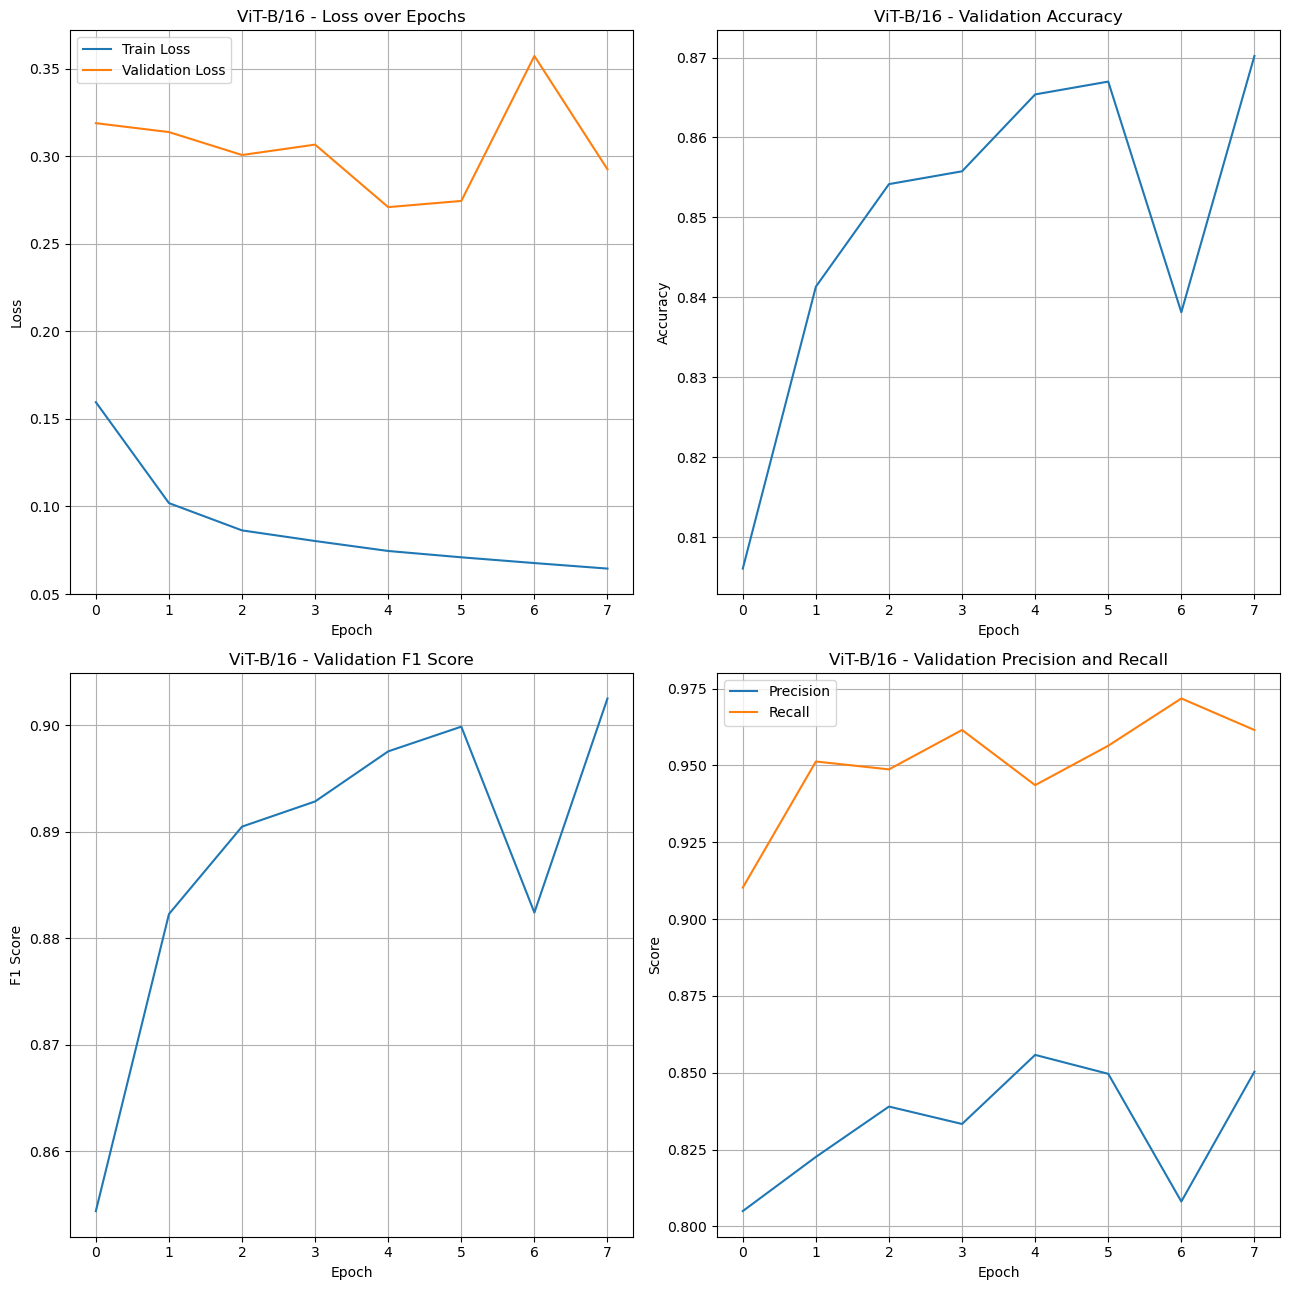

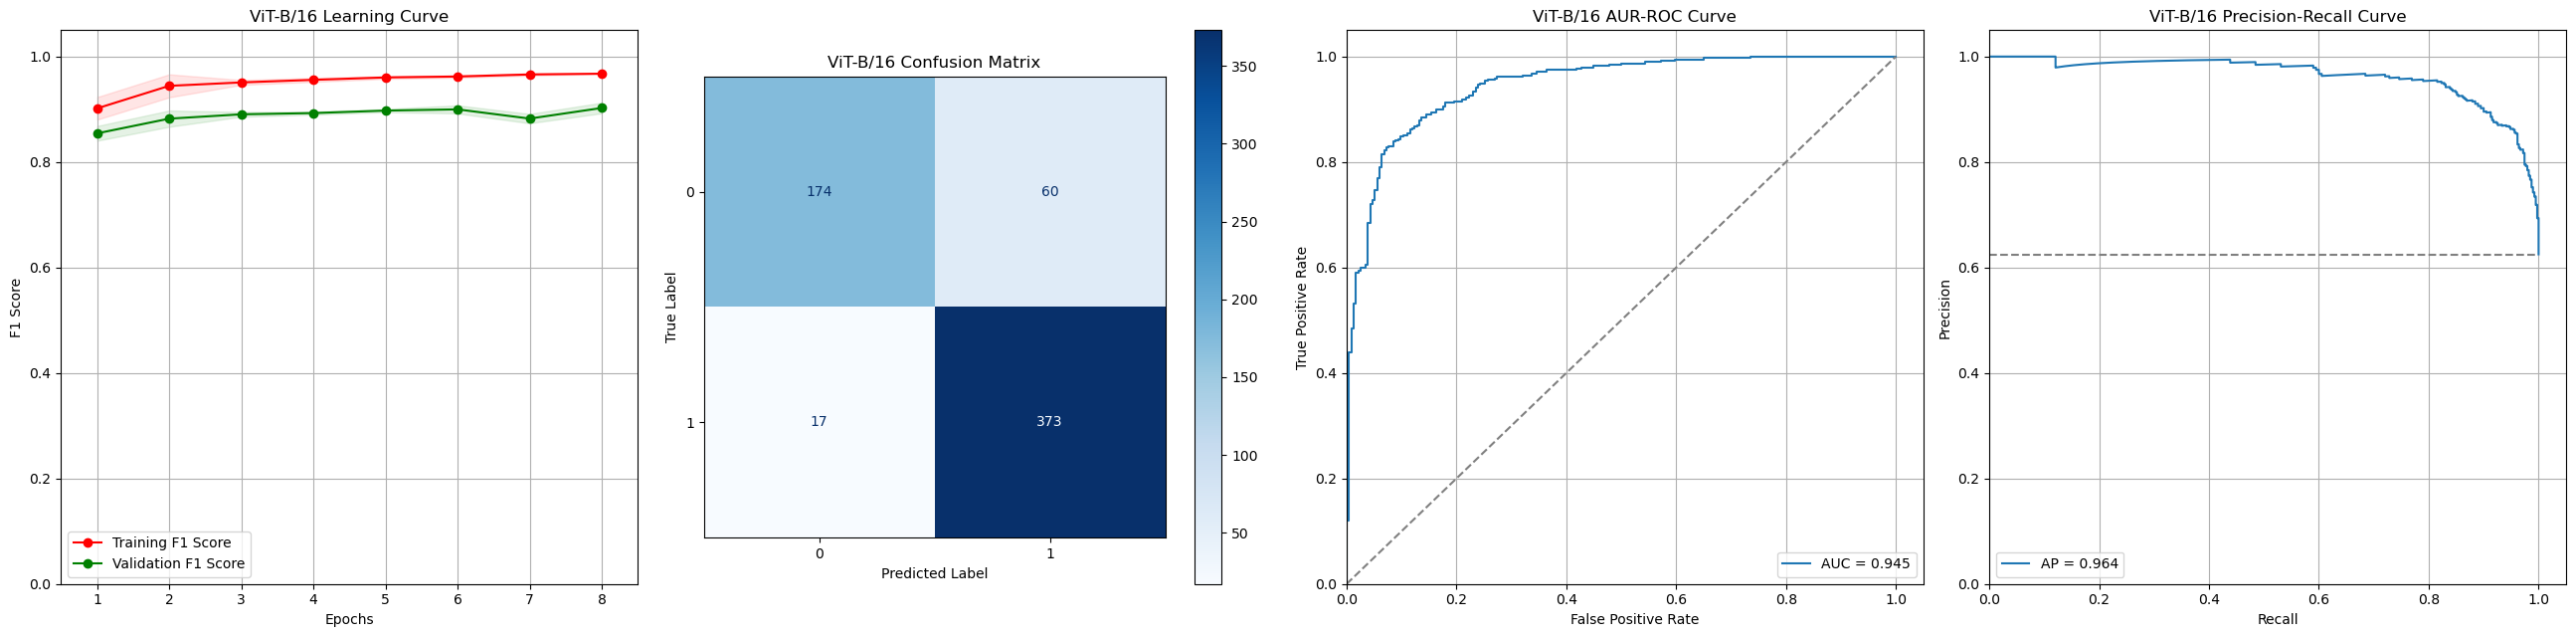

In [11]:
vit_model = create_vit_model()
vit_model, vit_metrics = train_model(
  vit_model, trainloader, testloader, model_name="ViT-B/16"
)

### **Model Tuning: Swin-T**
Train and evaluate a fine-tuned Swin-T model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [06:30<00:00,  2.38s/it]


Epoch 1/20, Training Loss: 0.1362
Training Accuracy: 0.9025, Precision: 0.9699, Recall: 0.8965, F1 Score: 0.9317
Validation Loss: 0.3164, Accuracy: 0.8958, Precision: 0.8719, Recall: 0.9769, F1 Score: 0.9214
New best validation loss: 0.3164


Epoch 2/20: 100%|██████████| 164/164 [06:40<00:00,  2.44s/it]


Epoch 2/20, Training Loss: 0.0746
Training Accuracy: 0.9453, Precision: 0.9862, Recall: 0.9395, F1 Score: 0.9623
Validation Loss: 0.4006, Accuracy: 0.8766, Precision: 0.8517, Recall: 0.9718, F1 Score: 0.9078
No improvement for 1 epochs


Epoch 3/20: 100%|██████████| 164/164 [06:30<00:00,  2.38s/it]


Epoch 3/20, Training Loss: 0.0665
Training Accuracy: 0.9524, Precision: 0.9898, Recall: 0.9457, F1 Score: 0.9672
Validation Loss: 0.4127, Accuracy: 0.8846, Precision: 0.8698, Recall: 0.9590, F1 Score: 0.9122
No improvement for 2 epochs


Epoch 4/20: 100%|██████████| 164/164 [06:07<00:00,  2.24s/it]


Epoch 4/20, Training Loss: 0.0658
Training Accuracy: 0.9566, Precision: 0.9888, Recall: 0.9524, F1 Score: 0.9702
Validation Loss: 0.6842, Accuracy: 0.8333, Precision: 0.7907, Recall: 0.9974, F1 Score: 0.8821
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.3164
Best threshold: 0.85 with F1 score: 0.9063

=== Final Model Evaluation ===
Loss: 0.6842
Accuracy: 0.8734
Precision: 0.8433
Recall: 0.9795
F1 Score: 0.9063


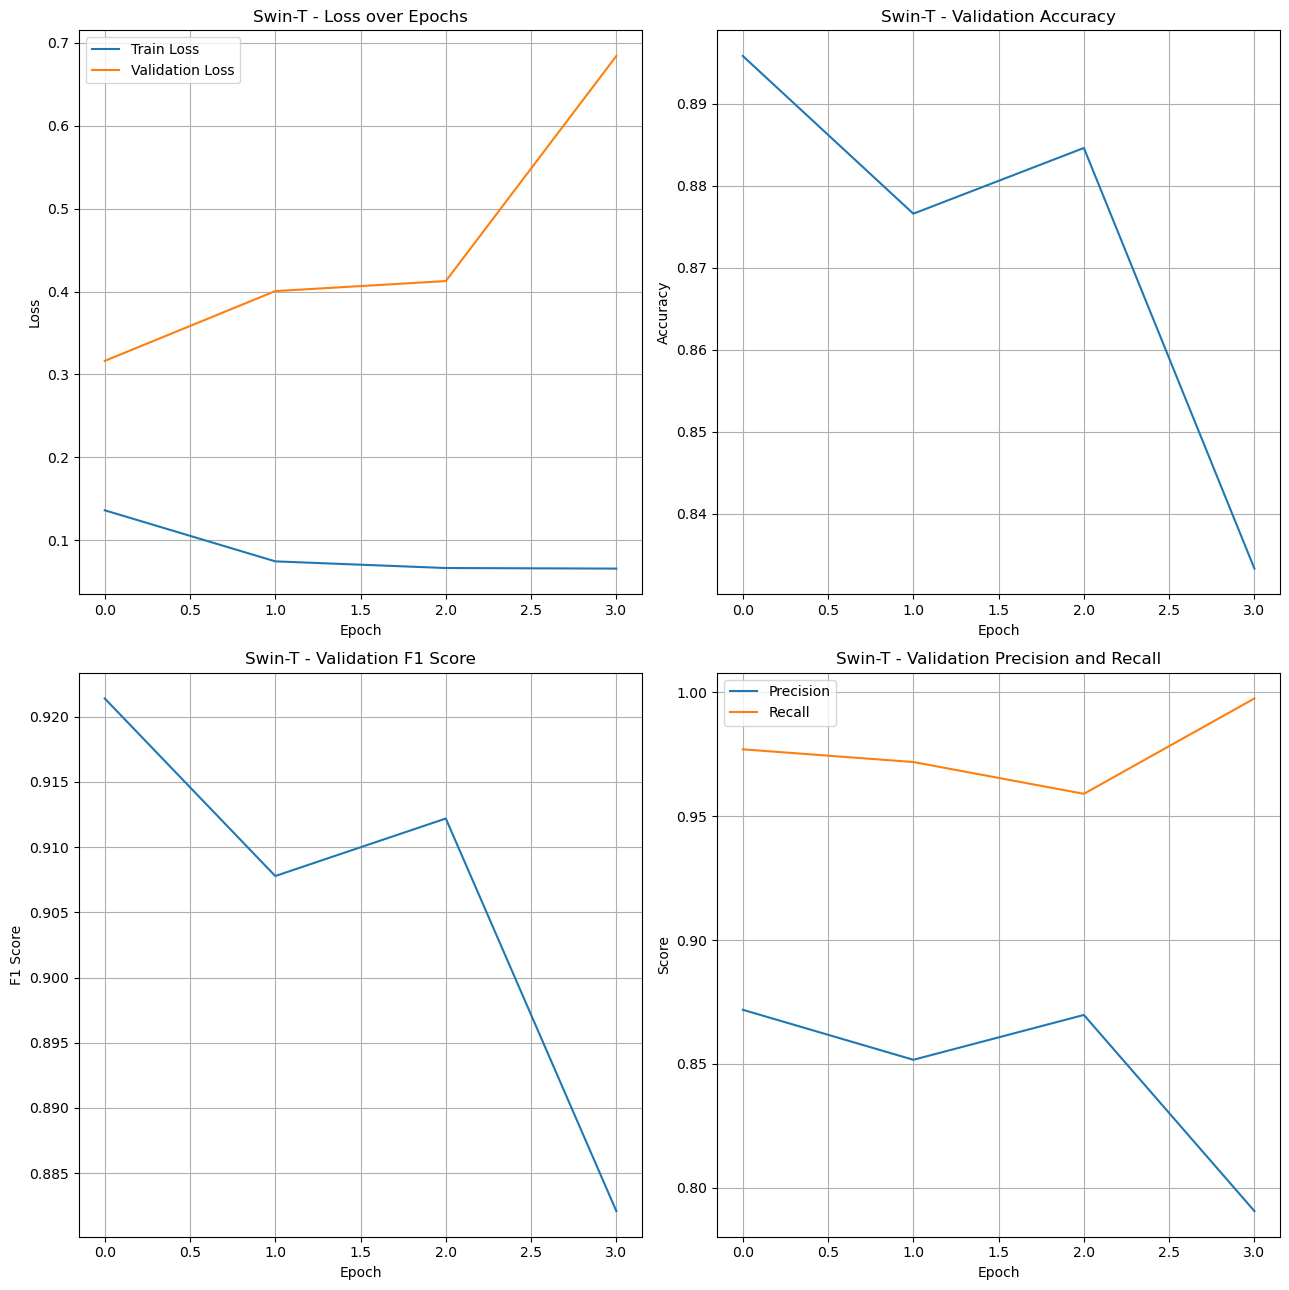

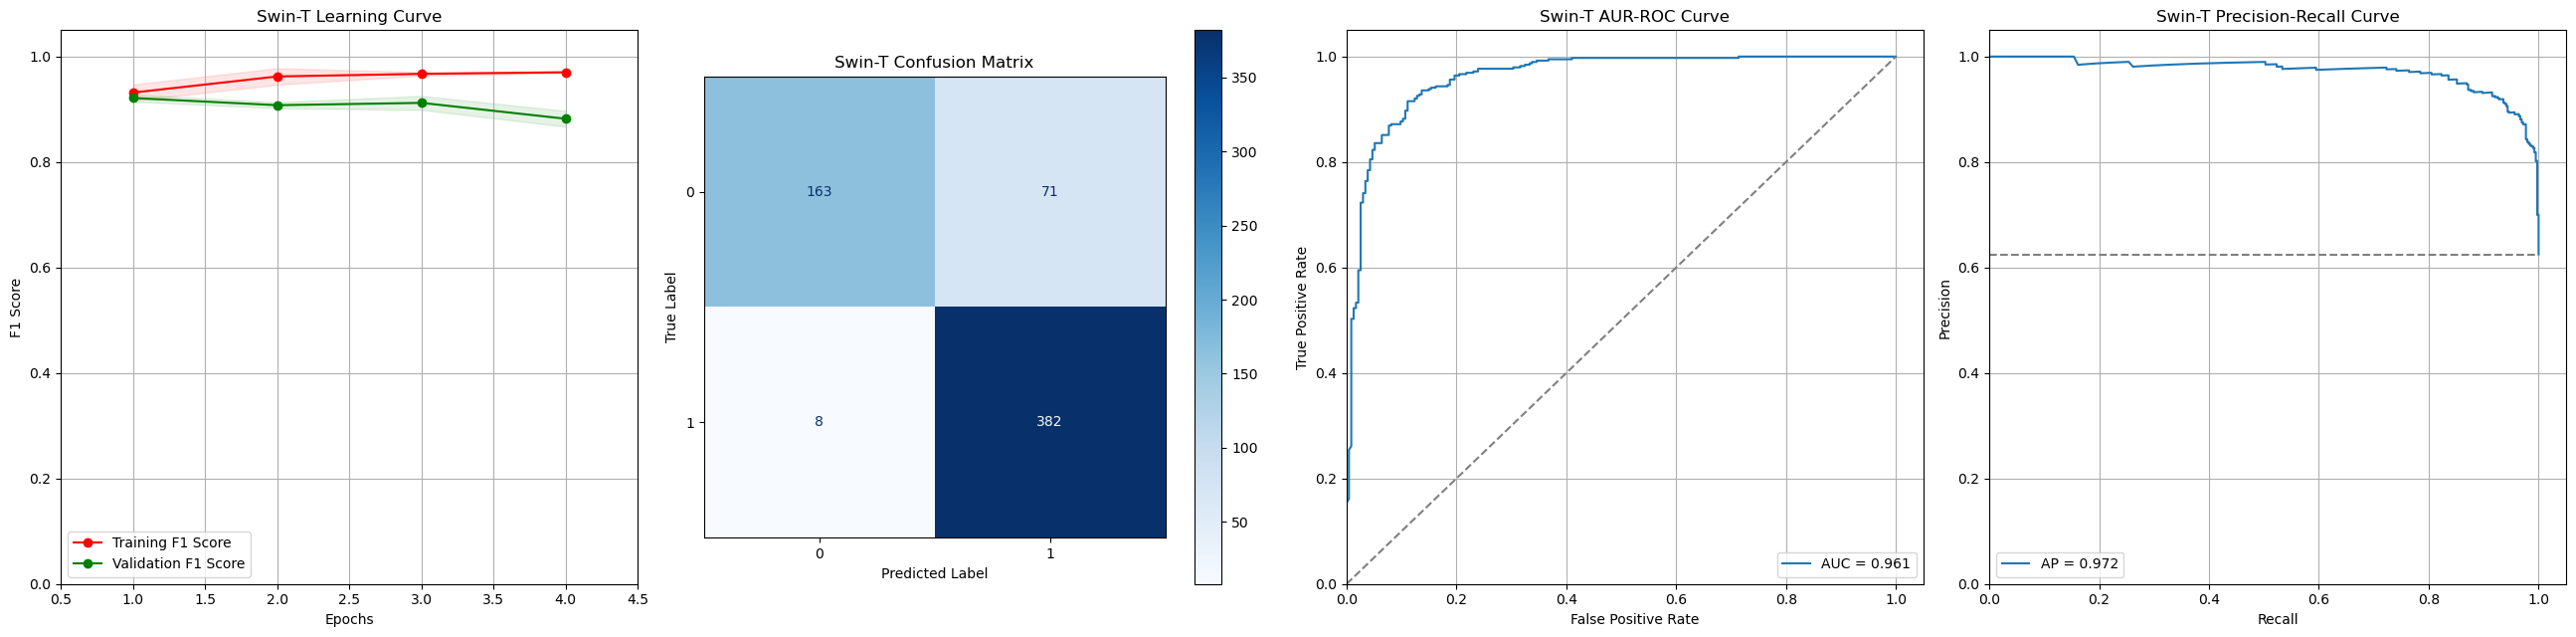

In [12]:
swin_model = create_swin_model()
swin_model, swin_metrics = train_model(
  swin_model, trainloader, testloader, model_name="Swin-T"
)

### **Model Tuning: ConvNeXt-T**
Train and evaluate a fine-tuned ConvNeXt-T model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [09:59<00:00,  3.65s/it]


Epoch 1/20, Training Loss: 0.0885
Training Accuracy: 0.9379, Precision: 0.9845, Recall: 0.9310, F1 Score: 0.9570
Validation Loss: 0.2306, Accuracy: 0.8942, Precision: 0.8990, Recall: 0.9359, F1 Score: 0.9171
New best validation loss: 0.2306


Epoch 2/20: 100%|██████████| 164/164 [10:07<00:00,  3.70s/it]


Epoch 2/20, Training Loss: 0.0490
Training Accuracy: 0.9677, Precision: 0.9915, Recall: 0.9647, F1 Score: 0.9779
Validation Loss: 0.7328, Accuracy: 0.7676, Precision: 0.7298, Recall: 0.9974, F1 Score: 0.8429
No improvement for 1 epochs


Epoch 3/20: 100%|██████████| 164/164 [10:02<00:00,  3.68s/it]


Epoch 3/20, Training Loss: 0.0419
Training Accuracy: 0.9740, Precision: 0.9929, Recall: 0.9719, F1 Score: 0.9823
Validation Loss: 0.2494, Accuracy: 0.8878, Precision: 0.8810, Recall: 0.9487, F1 Score: 0.9136
No improvement for 2 epochs


Epoch 4/20: 100%|██████████| 164/164 [10:02<00:00,  3.67s/it]


Epoch 4/20, Training Loss: 0.0319
Training Accuracy: 0.9799, Precision: 0.9945, Recall: 0.9784, F1 Score: 0.9864
Validation Loss: 0.5681, Accuracy: 0.8574, Precision: 0.8195, Recall: 0.9897, F1 Score: 0.8966
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2306
Best threshold: 0.80 with F1 score: 0.9097

=== Final Model Evaluation ===
Loss: 0.5681
Accuracy: 0.8782
Precision: 0.8473
Recall: 0.9821
F1 Score: 0.9097


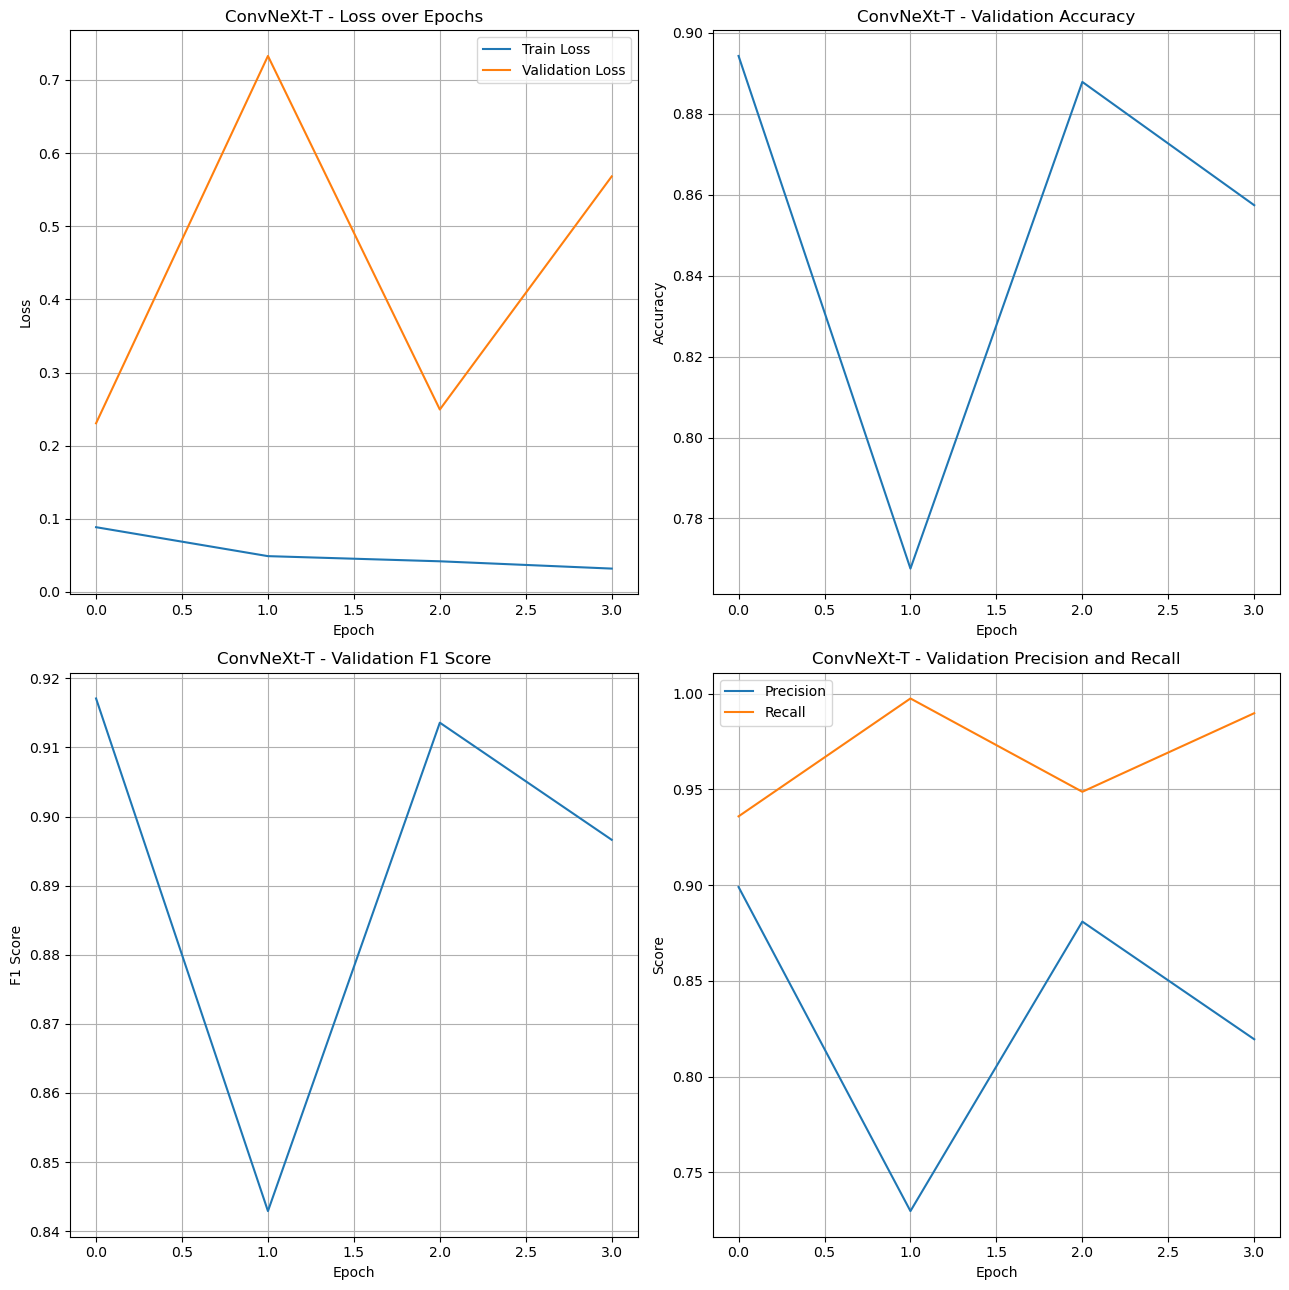

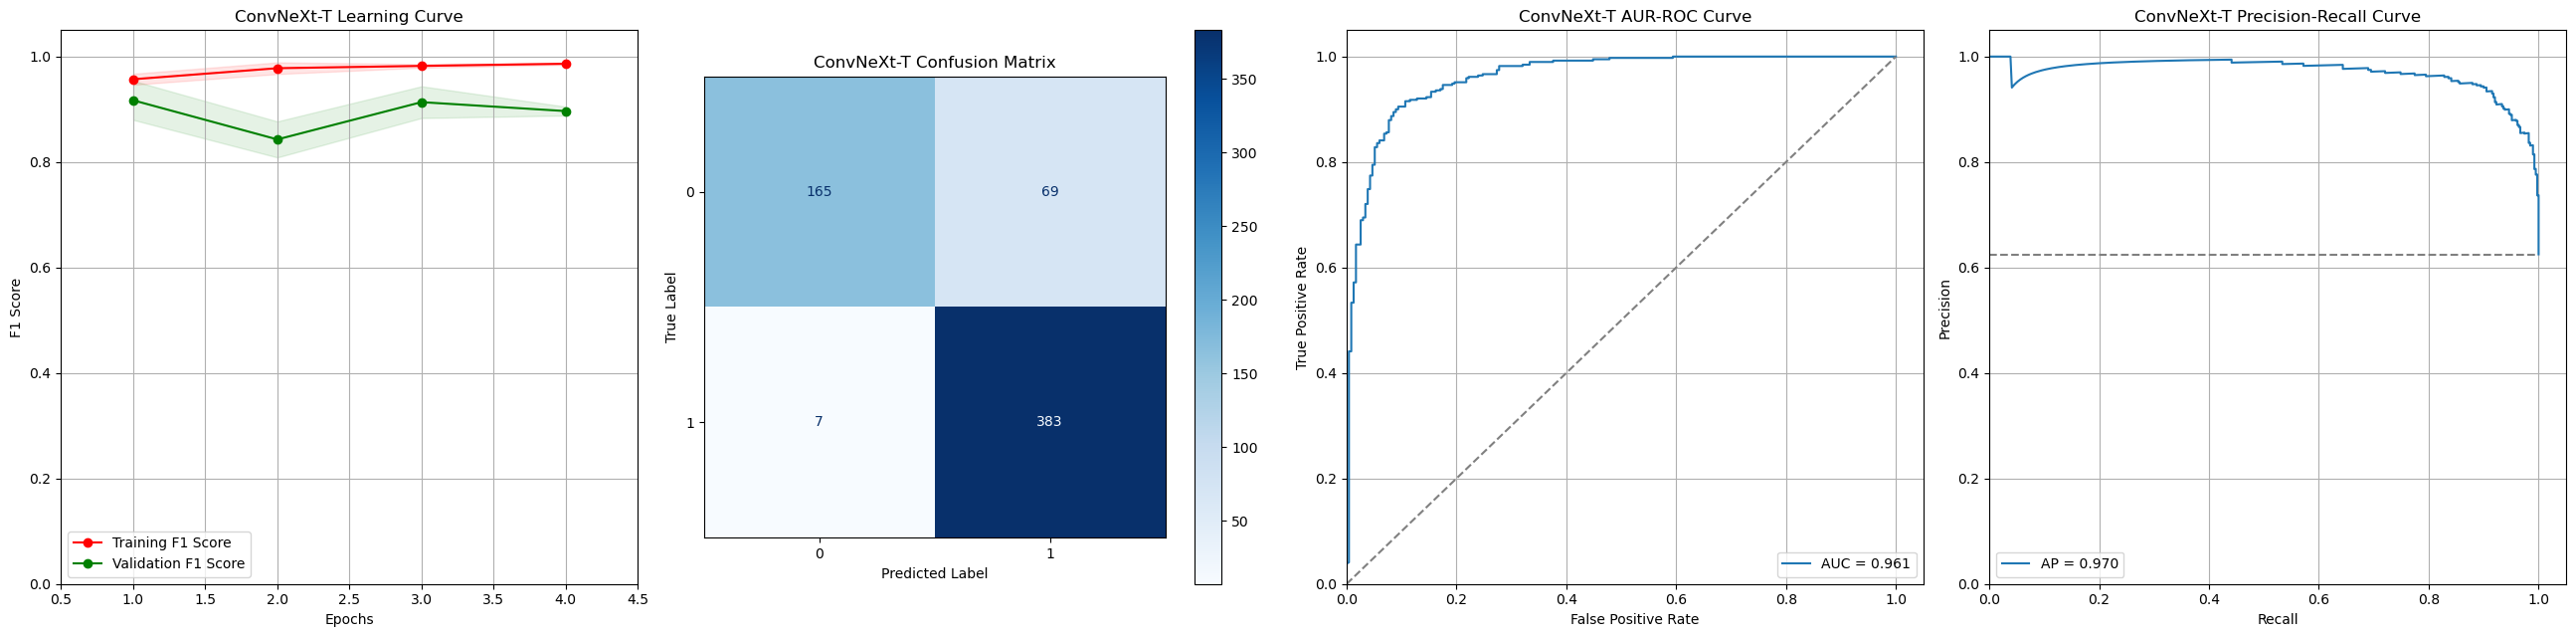

In [13]:
convnext_model = create_convnext_model()
convnext_model, convnext_metrics = train_model(
  convnext_model, trainloader, testloader, model_name="ConvNeXt-T"
)

### **Model Comparison**
Compare the performance of all models.

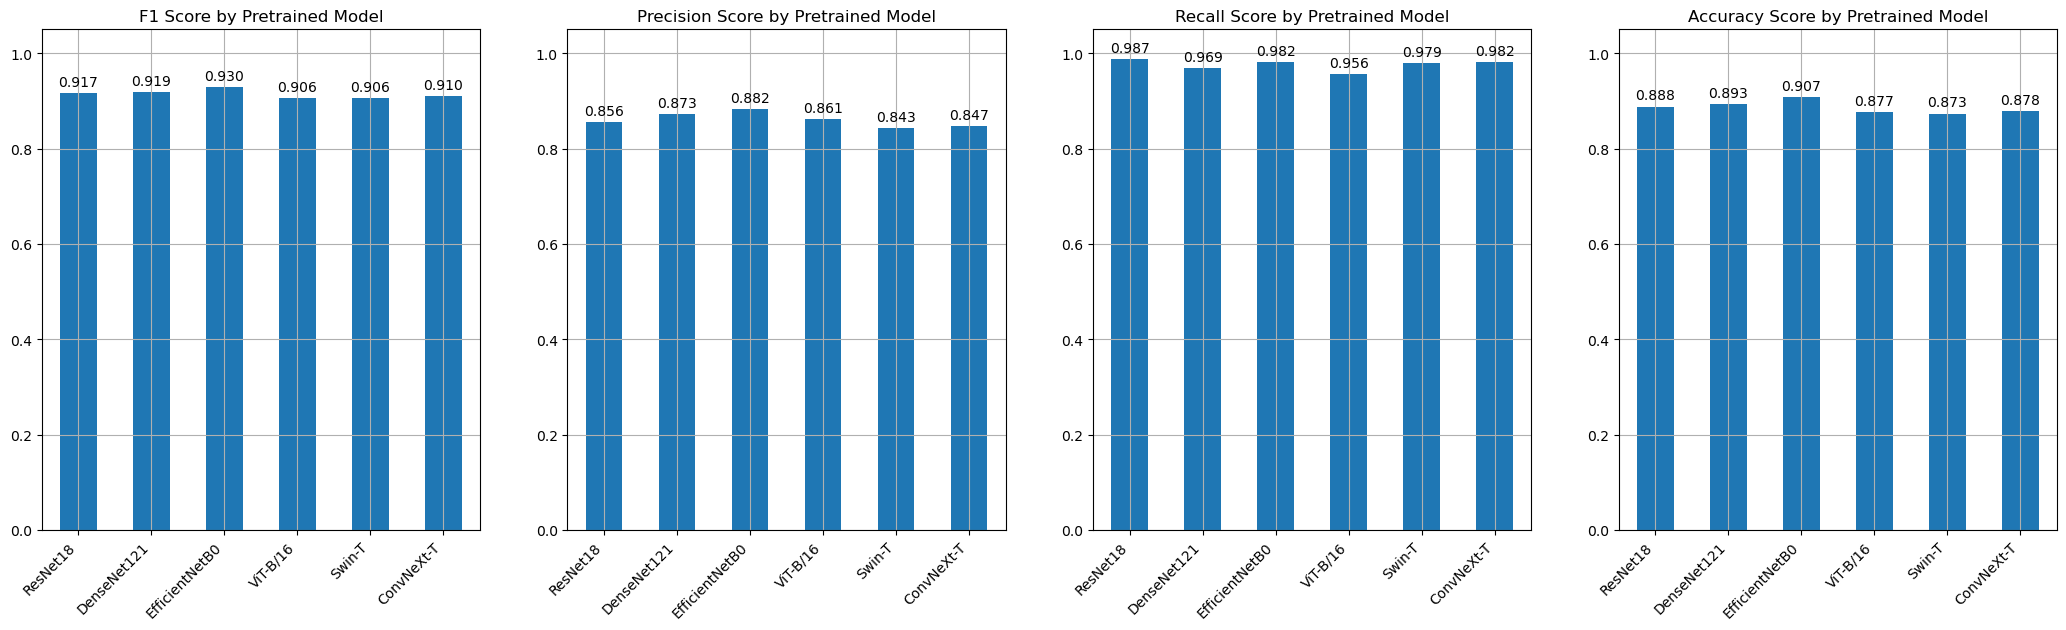

In [ ]:
model_names = [
  "ResNet18",
  "DenseNet121",
  "EfficientNetB0",
  "ViT-B/16",
  "Swin-T",
  "ConvNeXt-T",
]
metrics = [
  resnet_metrics,
  densenet_metrics,
  efficientnet_metrics,
  vit_metrics,
  swin_metrics,
  convnext_metrics,
]

comparison_df = pd.DataFrame(
  {
    "F1": [m["f1"] for m in metrics],
    "Precision": [m["precision"] for m in metrics],
    "Recall": [m["recall"] for m in metrics],
    "Accuracy": [m["accuracy"] for m in metrics],
  },
  index=model_names,
)

_, axs = plt.subplots(1, 4, figsize=(26, 6.5))
for index, col in enumerate(comparison_df.columns):
  ax = axs[index]
  bars = comparison_df.plot.bar(
    y=col,
    use_index=True,
    ylim=[0.0, 1.05],
    legend=False,
    grid=True,
    title=f"{col} Score by Pretrained Model",
    ax=ax,
  )
  ax.bar_label(bars.containers[0], fmt="%.3f", padding=3)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

### **Feature Visualization with Class Activation Maps**
Visualize what the model is focusing on using Grad-CAM.

In [15]:
import numpy as np
import torch
import cv2
from matplotlib import pyplot as plt


def visualize_gradcam(model, target_layer, image, label, model_name):
  # Set the model to evaluation mode
  model.eval()

  # Ensure we're working with a batch
  if len(image.shape) == 3:
    image = image.unsqueeze(0)

  # Check if the model expects 3 channels but image has 1 channel
  # Create a 3-channel version if needed
  if image.shape[1] == 1 and model_name in [
    "ResNet18",
    "DenseNet121",
    "EfficientNetB0",
    "ConvNeXt-T",
  ]:
    image_input = image.repeat(1, 3, 1, 1).clone().detach().requires_grad_(True)
  else:
    image_input = image.clone().detach().requires_grad_(True)

  # Store activations and gradients
  activations = []

  # Forward hook for the target layer
  def get_activations(module, input, output):
    activations.append(output.detach())

  # Register the hook
  handle = target_layer.register_forward_hook(get_activations)

  # Forward pass
  output = model(image_input)
  pred_class = torch.argmax(output).item()
  pred_score = torch.softmax(output, dim=1)[0, pred_class].item()

  # Clear gradients
  model.zero_grad()

  # Backward pass for the predicted class
  one_hot = torch.zeros_like(output)
  one_hot[0, pred_class] = 1
  output.backward(gradient=one_hot)

  # Get the gradients coming into the target layer
  gradients = image_input.grad

  # Get the activations of the last convolutional layer
  if not activations:
    handle.remove()
    raise ValueError(
      f"No activations captured for {model_name}. Check the target layer."
    )

  target_activations = activations[0]

  # Calculate the average gradient for each feature map channel
  weights = torch.mean(gradients, dim=[0, 2, 3])

  # Create the class activation map
  cam = torch.zeros(target_activations.size()[2:], device=target_activations.device)

  # Multiply each weight with its corresponding feature map
  for i, w in enumerate(weights):
    cam += w * target_activations[0, i, :, :]

  # Apply ReLU to focus on features that have a positive influence
  cam = torch.relu(cam)

  # Normalize the CAM
  if torch.max(cam) > 0:
    cam = cam / torch.max(cam)

  # Convert to numpy for visualization
  cam_np = cam.cpu().detach().numpy()

  # Original image for display
  original_img = image.squeeze(0).cpu().detach().numpy()

  # Handle different image formats
  if original_img.shape[0] == 1:  # Single channel
    original_img = original_img.squeeze(0)  # Remove channel dimension
    img_for_display = np.repeat(
      original_img[:, :, np.newaxis], 3, axis=2
    )  # Convert to 3 channels for display
  elif original_img.shape[0] == 3:  # RGB
    img_for_display = np.transpose(original_img, (1, 2, 0))  # CHW to HWC
  else:
    raise ValueError(f"Unexpected number of channels: {original_img.shape[0]}")

  # Normalize for visualization
  img_for_display = (img_for_display - np.min(img_for_display)) / (
    np.max(img_for_display) - np.min(img_for_display)
  )

  # Resize CAM to match the input image size
  h, w = original_img.shape[-2], original_img.shape[-1]
  cam_resized = cv2.resize(cam_np, (w, h))

  # Apply colormap
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

  # Create the overlay
  alpha = 0.4
  overlay = (1 - alpha) * img_for_display + alpha * heatmap

  # Create the visualization
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.imshow(img_for_display, cmap="gray" if original_img.shape[0] == 1 else None)
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(cam_resized, cmap="jet")
  plt.title("Grad-CAM")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(overlay)
  plt.title("Overlay")
  plt.axis("off")

  # Add overall title with prediction info
  class_name = "Normal" if pred_class == 0 else "Pneumonia"
  actual_class = "Normal" if label.item() == 0 else "Pneumonia"
  plt.suptitle(
    f"{model_name}: Actual: {actual_class}, Predicted: {class_name} ({pred_score:.2f})"
  )

  plt.tight_layout()
  plt.show()

  # Clean up
  handle.remove()

=== Visualization for Normal Case ===


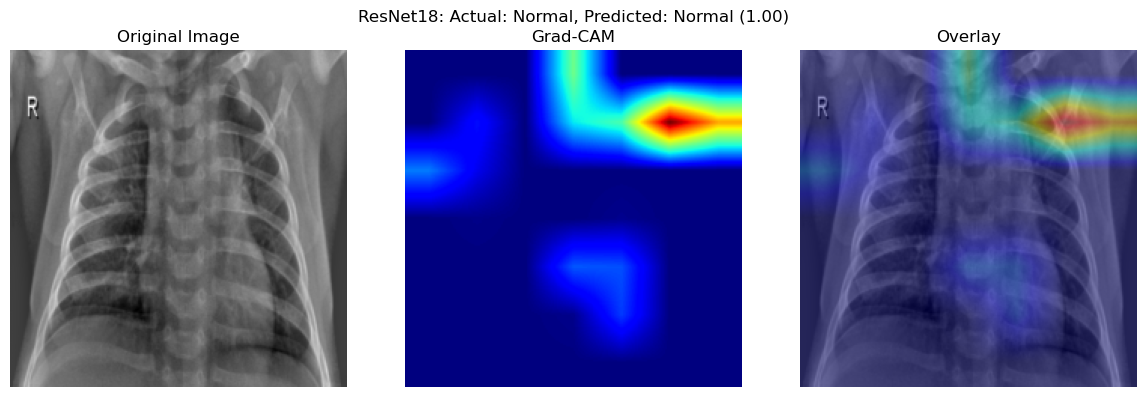

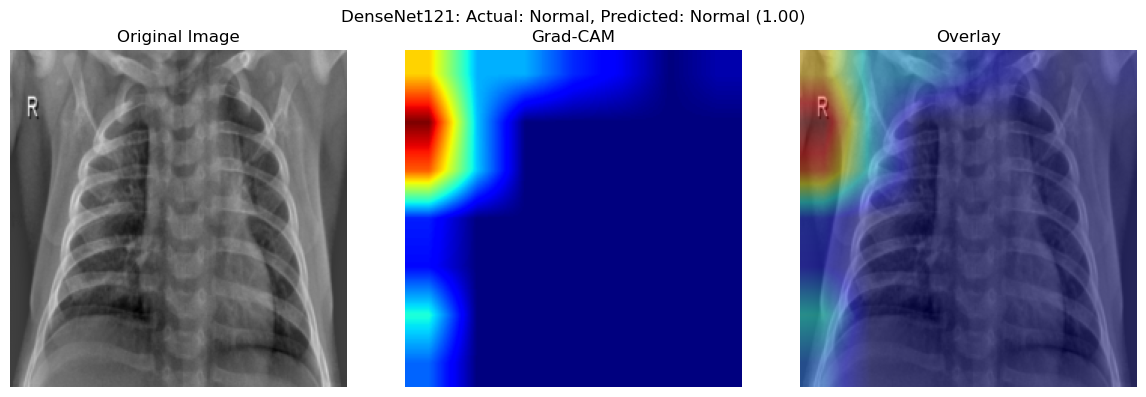

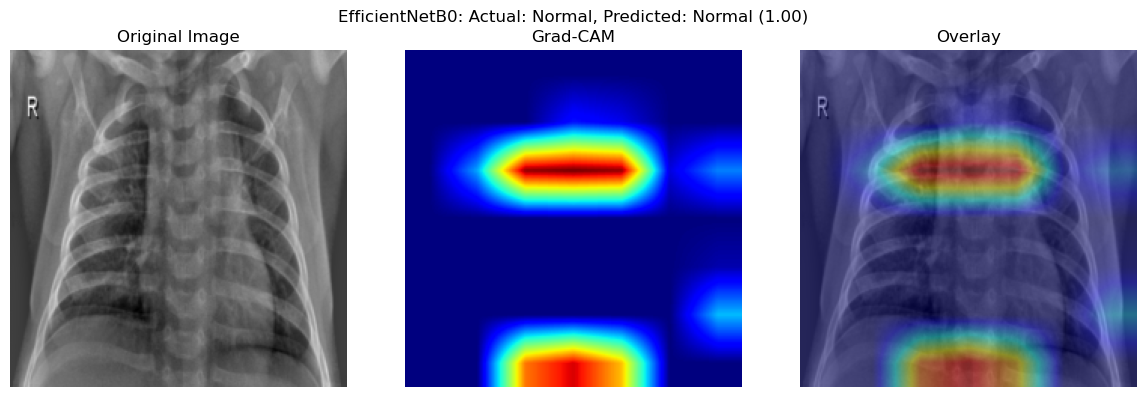

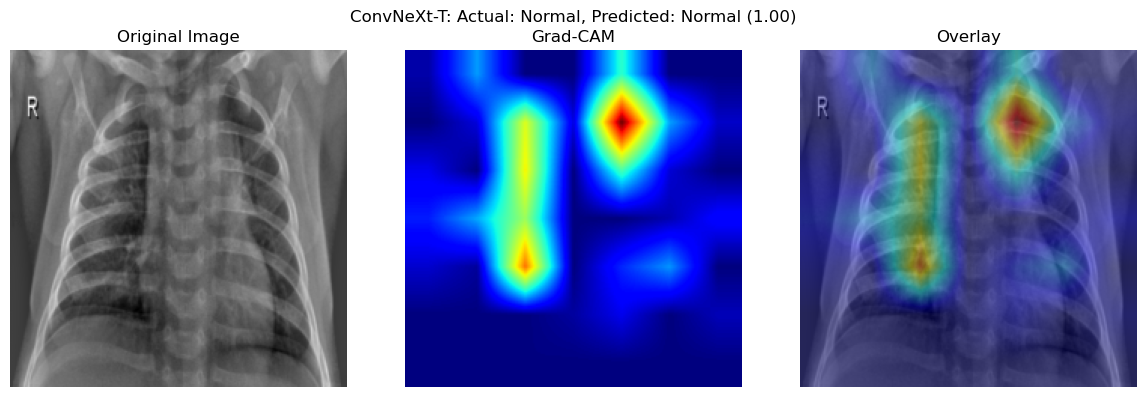


=== Visualization for Pneumonia Case ===


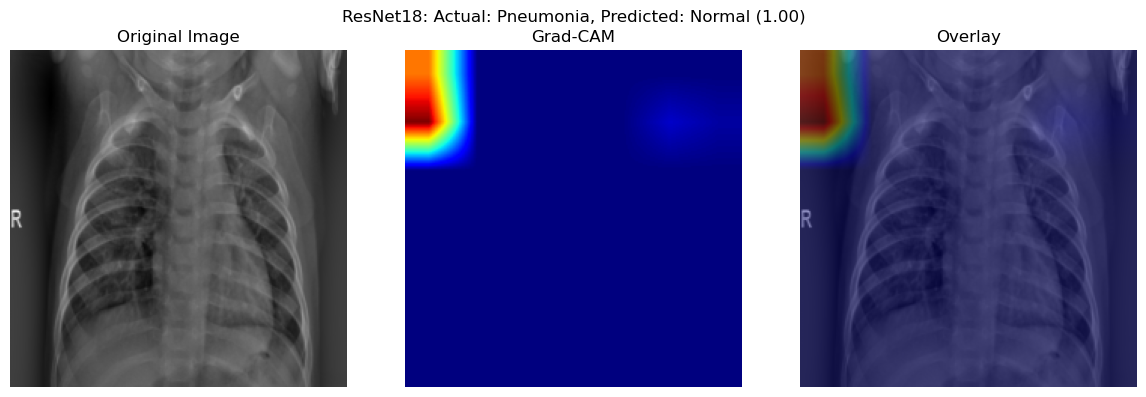

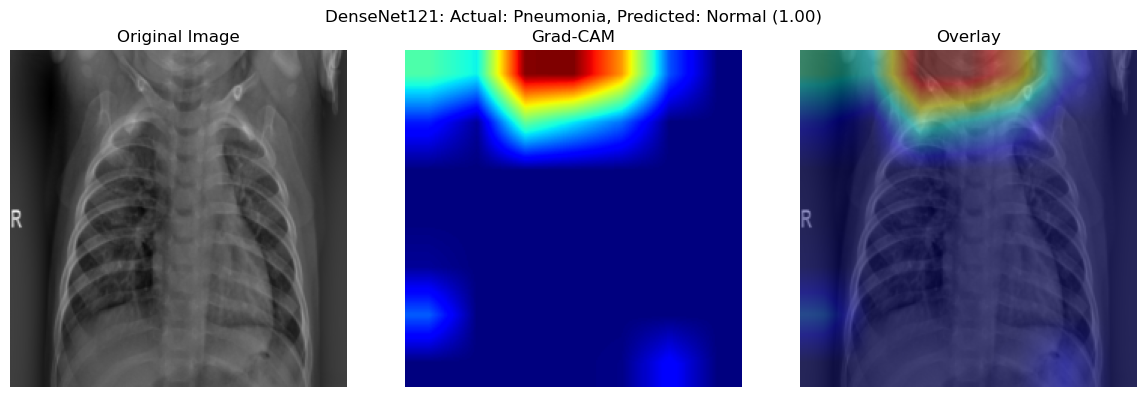

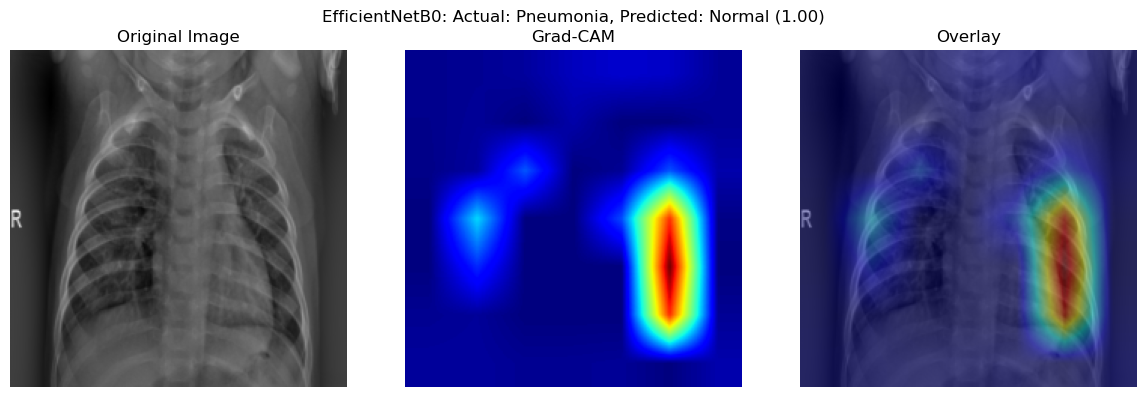

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


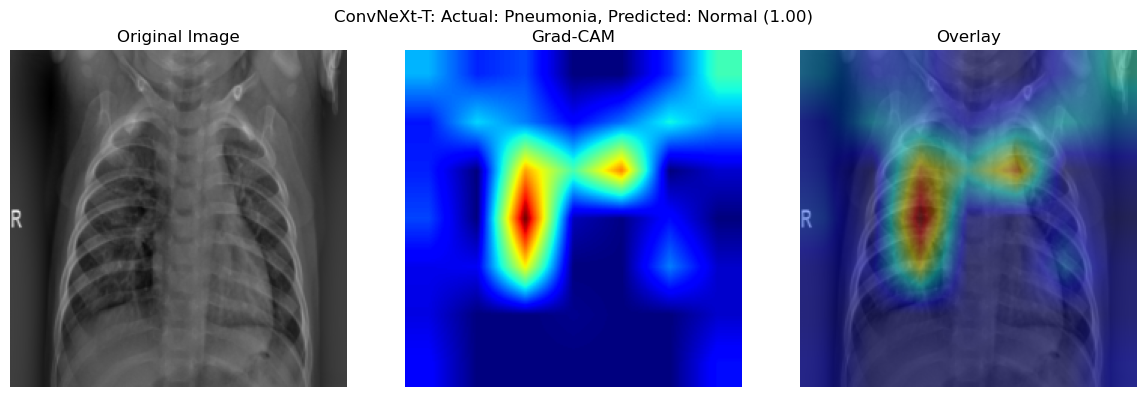

In [16]:
# Visualize a few examples
# For each model, visualize one normal case and one pneumonia case

# Get some samples from the test set
normal_indices = np.where(y_test.numpy() == 0)[0]
pneumonia_indices = np.where(y_test.numpy() == 1)[0]

# Sample one of each class
normal_sample_idx = np.random.choice(normal_indices)
pneumonia_sample_idx = np.random.choice(pneumonia_indices)

# Get the samples
normal_sample = X_test[normal_sample_idx]
normal_label = y_test[normal_sample_idx]
pneumonia_sample = X_test[pneumonia_sample_idx]
pneumonia_label = y_test[pneumonia_sample_idx]

# Define target layers for each model
resnet_target_layer = resnet_model.layer4[-1]
densenet_target_layer = densenet_model.features.denseblock4.denselayer16
efficientnet_target_layer = efficientnet_model.features[-1]
convnext_target_layer = convnext_model.features[-1]
vit_target_layer = vit_model.encoder.layers[-1]
swin_target_layer = swin_model.features[-1]


# Visualize for normal sample
print("=== Visualization for Normal Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, normal_sample, normal_label, "ResNet18"
)
visualize_gradcam(
  densenet_model, densenet_target_layer, normal_sample, normal_label, "DenseNet121"
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  normal_sample,
  normal_label,
  "EfficientNetB0",
)
visualize_gradcam(
  convnext_model, convnext_target_layer, normal_sample, normal_label, "ConvNeXt-T"
)

# Visualize for pneumonia sample
print("\n=== Visualization for Pneumonia Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, pneumonia_sample, pneumonia_label, "ResNet18"
)
visualize_gradcam(
  densenet_model,
  densenet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "DenseNet121",
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "EfficientNetB0",
)
visualize_gradcam(
  convnext_model, convnext_target_layer, pneumonia_sample, pneumonia_label, "ConvNeXt-T"
)